### Prep

In [7]:
import os
import torch
import torch.nn as nn
from tqdm.notebook import tqdm, trange
import torch.optim as optim
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
import random
import pickle
import datetime
import math
from pathlib import Path
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True  # Enforce deterministic algorithms
        torch.backends.cudnn.benchmark = False     # Disable benchmark for reproducibility

    os.environ['PYTHONHASHSEED'] = str(seed)       # Seed Python hashing, which can affect ordering
set_seed(42)

# DATASET_DIR = (Path("..") / ".." / "datasets").resolve()
# DATASETS = ["OFFICE-MANNERSDB", "MANNERSDBPlus"]
# LABEL_COLS = [
#     "Vaccum Cleaning", "Mopping the Floor", "Carry Warm Food",
#     "Carry Cold Food", "Carry Drinks", "Carry Small Objects",
#     "Carry Large Objects", "Cleaning", "Starting a conversation"
# ]

import sys
sys.path.append('..')

from data_processing.data_processing import get_domain_dataloaders, combine_all_dataloaders
from models.heuristicSplitModel import DualBranchModel

In [8]:
df = pd.read_pickle("../data/pepper_data_train.pkl")

## Evaluation

### files

In [ ]:
# different cos 1-abs fixed residual - fixedred_fixedcos_dualbranchmodel_20250604_014811_history
#fixed res but old cosine ^2 - fixedred_dualbranchmodel_20250604_002951_history
#broken baseline - baselinemodel_20250603_200948_history
# recent dualbranch - dualbranchmodel_20250603_135728_history
#normalised and standarised residual - dualbranchmodel_20250609_013632_history
#standarised residual - nonorm_dualbranchmodel_20250609_131820_history
#no residual connection - nores_dualbranchmodel_20250609_232842_history
#same plus gradient clipping - nores_gradclip_dualbranchmodel_20250610_010647_history
#same, no graidient clipping, weights initialisation and normalisation - nores_winit_wnorm_dualbranchmodel_20250610_024401_history
#same, gradient clipping and weights optimisation - nores_gradclip_winit_wnorm_dualbranchmodel_20250610_042118_history
#deeper invariant network - deep_norm_dualbranchmodel_20250610_223350_history
#same but with weiths normalisation - deep_dualbranchmodel_20250610_205411_history

with open('../checkpoints/nonorm_dualbranchmodel_20250609_131820_history.pkl', 'rb') as f:
    nonorm = pickle.load(f)

with open('../checkpoints/nores_dualbranchmodel_20250609_232842_history.pkl', 'rb') as f:
    lnorm_nores = pickle.load(f)

with open('../checkpoints/nores_gradclip_dualbranchmodel_20250610_010647_history.pkl', 'rb') as f:
    lnorm_nores_gradclip = pickle.load(f)

with open('../checkpoints/dualbranchmodel_20250609_013632_history.pkl', 'rb') as f:
    lnorm = pickle.load(f)

with open('../checkpoints/nores_winit_wnorm_dualbranchmodel_20250610_024401_history.pkl', 'rb') as f:
    wnorm_nores = pickle.load(f)

with open('../checkpoints/nores_gradclip_winit_wnorm_dualbranchmodel_20250610_042118_history.pkl', 'rb') as f:
    wnorm_nores_gradclip = pickle.load(f)

with open('../checkpoints/deep_norm_dualbranchmodel_20250610_223350_history.pkl', 'rb') as f:
    wnorm_gradclip_deep = pickle.load(f)

with open('../checkpoints/deep_dualbranchmodel_20250610_205411_history.pkl', 'rb') as f:
    lnorm_gradclip_deep = pickle.load(f)

In [ ]:
# all have gradient clipping
# Either detach and skip connect base -> head
# - detach reference - how does detachement work? can backbone learn through skip connection?
# - detach smaller batch effect?
# - detach how partial freeze backbone learns?
# or
# freeze backbone
# - frozen backbone doesn't learn, branches learn solo
# - frozen, branches solo learn but binary?
# - frozen branches solo learn binary but explicit gradient reverse function rather than layer?
# - add full replay? 

files = [
    'bbdetach_deep_dualbranchmodel_20250613_155613_history',                 #deep weights_init=False, detach_base=True, - base for below  experiments
    'bdetach_batch16_dualbranchmodel_20250615_025032_history', # deep unfrozen bb, detached bb, smaller 16 batch - did smaller batch improve stability, did skip connection improve head loss and total training/val loss?
    'bdetach_pfrozen_dualbranchmodel_20250615_040906_history', # deep pfrozen bb, detached bb - training branches+last layer bb - did partially frozen pretrained backbone improve skip head connection?
   
    'ffrozen_dualbranchmodel_20250615_133027_history',                       #deep weights_init=False, detach_base=False, -how do deep linear branches train on their own?
    'ffrozen_binary_dualbranchmodel_20250615_153755_history',                      #weights_init=False, detach_base=False, explicit_grl=False, full_replay = False - does binary improve anything?
    'ffrozen_binary_explicitgrl_dualbranchmodel_20250615_162820_history',          #weights_init=False, detach_base=False, explicit_grl=False, full_replay = False - does the gradient reversal layer work better or function?
    'freplay_ffrozen_binary_explicitgrl_dualbranchmodel_20250615_174623_history'  #weights_init=True,  detach_base=False, explicit_grl=True,  full_replay = True - does full repaly help the branches on their own?
]

In [ ]:
files = [
    # 'CNN_pretrained_simple_simple_dualbranchmodel_20250616_032555_history',  # 'pretrained_backbone_cnn_branch': ('pretrained', 'simple', 'simple'), 
    # 'CNN_diy_backbone_linear_branch_dualbranchmodel_20250616_105211_history', # (2layer convolution backbone, 'linear', 'simple'),
    # 'CNN_linear_branch_dualbranchmodel_20250616_172252_history',  # 'linear_branch': ('3conv', 'linear', 'simple'),
    'CNN_cnn_branch_dualbranchmodel_20250616_190434_history',      # 'cnn_branch': ('3conv', 'simple', 'simple'),
    'CNN_adversarial_dualbranchmodel_20250616_201008_history',      # 'adversarial': ('2conv', 'adversarial', 'adversarial'),
    'CNN_cnn_specialised_branches_dualbranchmodel_20250616_232330_history',      # 'cnn_specialised_branches': ('3conv', 'special', 'simple')
    'CNN_pretrained_simple_0.25branches_dualbranchmodel_20250617_230422_history',
    'CNN_pretrained_special_dualbranchmodel_20250617_032445_history'
]


    

In [ ]:
files = ['CNN_pretrained_simple_dualbranchmodel_20250617_022356_history', #'pretrained_simple': ('pretrained', 'simple', '3linear', detach_base=False), 
'CNN_pretrained_special_dualbranchmodel_20250617_032445_history', #    'pretrained_special': ('pretrained', 'special', '3linear', False),
'CNN_3conv_simple_dualbranchmodel_20250617_042555_history', #    '3conv_simple': ('3conv', 'simple', '3linear', True),
'CNN_3conv_special_dualbranchmodel_20250617_052951_history' #    '3conv_special': ('3conv', 'special', '3linear', True),
]

In [ ]:
files = ['CNN_pretrained_simple_dualbranchmodel_20250617_022356_history',
'CNN_pretrained_simple_0.25branches_dualbranchmodel_20250617_230422_history' #change the loss proportions
]

In [ ]:
files =['5foldcrossval_fold4_CNN_3conv_adversarial_dualbranchmodel_20250618_121607_history',
'5foldcrossval_fold4_CNN_pretrained_simple_dualbranchmodel_20250618_064848_history'
]
files = [
    'CNN_pretrained_simple_0.25branches_dualbranchmodel_20250617_230422_history',
    'CNN_adversarial_dualbranchmodel_20250616_201008_history'
]

In [ ]:
files = ['DANN_dualbranchmodel_20250618_152753_history',
         'DANN_dynamicalpha_notrain1dom_20250620_201349_history',
         'DANN_dynamicalpha_notrain1dom_20250620_232330_history'
         ]

In [ ]:
files = [
'baselinemodel_20250618_195623_history',
'minimal_simple_dualbranchmodel_20250618_213930_history',
'minimal_simple_buffer05_dualbranchmodel_20250618_224113_history',
'minimal_special_dualbranchmodel_20250618_233832_history'
]


In [ ]:
files=[
'baselinemodel_20250603_200948_history',
'baselinemodel_20250603_034233_history',
'baselinemodel_20250618_195623_history'
]

In [ ]:
files = [
    'baselinemodel_20250603_200948_history',
    'minimal_absurd_buff500_20250619_121348_history',
    'minimal_simple_buffer05_dualbranchmodel_20250618_224113_history',
    'DANN_dualbranchmodel_20250618_152753_history',
    'CNN_pretrained_simple_0.25branches_dualbranchmodel_20250617_230422_history'
    ]

In [ ]:
files = [
'DANN_dynamicalpha_notrain1dom_20250620_232330_history',
'DANN_notrain1dom_20250621_005208_history',
]

In [ ]:
files = [
'dualbranch_CNN_dynamicalpha_20250621_015610_history',
'CNN_adversarial_dualbranchmodel_20250616_201008_history',
'CNN_cnn_branch_dualbranchmodel_20250616_190434_history'
]

In [ ]:
files =[
'dualbranch_CNN_1epoch_20250621_014841_history',
'CNN_pretrained_simple_025branches_dualbranchmodel_20250617_230422_history',
'CNN_pretrained_simple_dualbranchmodel_20250617_022356_history',
'CNN_adversarial_dualbranchmodel_20250616_201008_history'
]

In [ ]:
files = [
'3conv_simple_3linear_bnorm_nogradclip_20250621_130858_history',
'3conv_simple_simple_bnorm_20250621_121437_history',
'3conv_simple_simple_bnorm_nogradclip_20250621_102634_history',
'3conv_simple_simple_nogradclip_20250621_112040_history',
]

In [ ]:
files =['mobinev2_dann_20250621_204449_history',
        'deeplabv3mobilenetv3_dann_20250621_223924_history',
        'deeplabv3mobilenetv3_dann_20250624_000526_history'
        ]

In [ ]:
files = [
    # ('dann', 'dann_mobilenet_20250630_014020_history'), #smoother, stable disentagnlement but not significantly better results
    # ('dann_old', 'mobinev2_dann_20250621_204449_history'), #old mobilenet dann
    ('detached', 'dual_2conv_adversarial_3linear_detach_20250630_045130_history'),
    ('detached_old', 'CNN_3conv_simple_dualbranchmodel_20250617_042555_history'), #detached old
    ('trainable_old', 'CNN_adversarial_dualbranchmodel_20250616_201008_history'), #trainable backbone pretrained adv adv old
    ('frozen', 'dual_mobilenet_simple_3linear_20250630_081954_history'),
    ('frozen_old', 'CNN_pretrained_simple_dualbranchmodel_20250617_022356_history'), #pretrained simple, 3linear old
    # 'dual_mobilenet_linear_simple_20250630_111817_history',  #performs poorly, no surprise taht linear layer canot extract meaningfull features from frozen backbone
    # ('baseline', 'baseline_20250630_161803_history'), #more stable, similar results
    # ('baseline_old', 'baselinemodel_20250618_195623_history'), #old baseline
]

In [ ]:
files = [
('linear', 'dual_mobilenet_linear_simple_20250630_111817_history'),
('linear_b120', 'dual_mobilenet_linear_simple_buff120_20250704_081958_history'), 
('base', 'baseline_20250630_161803_history'),
('base_b500', 'baseline_buff500_20250704_085427_history'), 
('base_b120', 'baseline_buff120_20250704_113155_history'), 
('dann', 'dann_mobilenet_20250630_014020_history'),
('dann_b500', 'dann_mobilenet_buff500_20250704_003743_history'), 
('dann_b120', 'dann_mobilenet_buff120_20250704_031423_history'), 
('detach', 'dual_2conv_adversarial_3linear_detach_20250630_045130_history'),
('detach_b500', 'dual_2conv_adversarial_3linear_detach_buff500_20250704_041620_history'), 
('detach_b120', 'dual_2conv_adversarial_3linear_detach_buff120_20250704_054532_history'),
('frozen', 'dual_mobilenet_simple_3linear_20250630_081954_history'), 
('frozen_b500', 'dual_mobilenet_simple_3linear_buff500_20250704_062411_history'), 
('frozen_b120', 'dual_mobilenet_simple_3linear_buff120_20250704_074516_history'),
]

In [ ]:
files = [
('base_b500', 'baseline_buff500_20250704_085427_history'), 
('base_b120', 'baseline_buff120_20250704_113155_history'), 
('new_b500','heuristic_dualbranch_buff500_20250704_213101_history'),
('new_b120','heuristic_dualbranch_buff120_20250705_031333_history'),
('frozen_b500', 'dual_mobilenet_simple_3linear_buff500_20250704_062411_history'), 
('frozen_b120', 'dual_mobilenet_simple_3linear_buff120_20250704_074516_history'),


]

In [ ]:
files = [
    ('base_b120', 'baseline_buff120_20250704_113155_history'),
]

In [ ]:
files = [
('base_b500', 'baseline_buff500_20250704_085427_history'), 
('base_b120', 'baseline_buff120_20250704_113155_history'), 
('new_b500','heuristic_dualbranch_buff500_20250704_213101_history'),
('new_b120','heuristic_dualbranch_buff120_20250705_031333_history'),
('frozen_b500', 'dual_mobilenet_simple_3linear_buff500_20250704_062411_history'), 
('frozen_b120', 'dual_mobilenet_simple_3linear_buff120_20250704_074516_history'),
('old_b500', 'CNN_pretrained_simple_dualbranchmodel_20250617_022356_history'), 
('linear_b1000', 'dual_mobilenet_linear_simple_20250630_111817_history'),
]

In [ ]:
files = [
    ('base','heuristic_dualbranch_buff120_20250705_031333_history'),
    # ('small_env','heuristic_small_env_20250722_222924_history'),
    # ('square','heuristic_square_img_20250722_233743_history'),
    ('eval_buffer','heuristic_eval_buffer_20250723_144515_history'),
]

In [ ]:
files = [
    ('base','heuristic_dualbranch_buff120_20250705_031333_history'),
    ('small','heuristic__small_imgs_20250729_151705_history'),
    ('small_env','heuristic_small_env_20250722_222924_history'),
    
]


In [ ]:
files = [
    ('standard','heuristic_HB2B3HlMS_20250729_225000_history'),
    ('no_mask','heuristic_og_img_20250730_104932_history'),
    ('only_soc','heuristic_soc_img_20250730_120730_history'),
    ('only_env','heuristic_env_img_20250730_122317_history'),
    
]

In [ ]:
files = [
    ('30e','heuristic_HB2B3HlMS_epoch30_20250730_130131_history'),
]

In [ ]:
files = [
    ('mobilenet','ablations/mobilenetv2_base_dropout0.1_epochs30_20250803_192234_history'),
    ('simple','simplebranch_epochs30_dropout0.1__20250805_215448_history'),
    ('simplenorm','simplebranch_branchnorm_epochs30_dropout0.1__20250806_005342_history'),
    ('mobilenet3e','mobilenetv2_epochs3_dropout0.1__20250806_050302_history'),
    ('mobilenetnorm','mobilenetv2_branchnorm_epochs30_dropout0.1__20250806_025510_history'),
]

In [ ]:
import os

pkl_files = [f for f in os.listdir('../checkpoints/') if f.endswith('.pkl')]
for file in pkl_files:
    print(file)

In [ ]:
import pickle
models = {}
for i, file in enumerate(files):
    file_name = ''
    if isinstance(file, tuple):
        file_name, file = file
    with open(f'../checkpoints/{file}.pkl', 'rb') as f:
        model_name = file_name or '_'.join(file.split('_')[:-3])+str(i)
        models[model_name] = pickle.load(f)

In [ ]:
# For fold histories
for k,m in models.items():
    models[k] = combine_fold_histories(m)

In [ ]:
models2 = models

In [ ]:
models.update(models2)

In [ ]:
with open('../checkpoints/bbdetach_deep_dualbranchmodel_20250613_155613_history.pkl', 'rb') as f:
    bbdetach_deep = pickle.load(f)


In [ ]:
for model in models.keys():
    print(model)

In [ ]:
for i in list(models.keys())[1:]:
    for j in models[i]['cross_domain_val']:
        for key in j:
            j[key] = j[key][0]

In [ ]:
for i in list(models.keys())[1:]:
    models[i]['val_epoch_loss'] = [j[0] for j in models[i]['val_epoch_loss']]
    models[i]['val_buffer_epoch_loss'] = [j[0] for j in models[i]['val_buffer_epoch_loss']]

In [ ]:
files = {
    "mobilenetv2_base": "../checkpoints/ablations/mobilenetv2_base_dropout0.1_epochs30_20250803_192234_domainSmallOffice_epoch29_step1770.pt",
    "simple_base": "../checkpoints/simplebranch_epochs30_dropout0.1__20250805_215448_domainSmallOffice_epoch29_step1770.pt",
    "mobilenetv2_e3base": "../checkpoints/mobilenetv2_epochs3_dropout0.1__20250806_050302_domainSmallOffice_epoch2_step177.pt",
    "mobilenetv2_normbase": "../checkpoints/mobilenetv2_branchnorm_epochs30_dropout0.1__20250806_025510_domainSmallOffice_epoch29_step1770.pt",
    "simple_normbase": "../checkpoints/simplebranch_branchnorm_epochs30_dropout0.1__20250806_005342_domainSmallOffice_epoch29_step1770.pt",
}

In [ ]:
files = {
    "mobilenetv2_base": "../checkpoints/ablations/mobilenetv2_base_dropout0.1_epochs30_20250803_192234_domainSmallOffice_epoch29_step1770.pt",
    "mobilenetv2_basetest": "../checkpoints/heuristic_HB2B3HlMS_epoch30_20250730_130131_domainSmallOffice_epoch29_step1770.pt"
}
#old models evaluated on test during training are faulty

In [ ]:
files = {
    'mobilenetv2_base': '../checkpoints/mobilenetv2_ablationbase_epochs30_20250812_232237_domainSmallOffice_epoch29_step1770.pt',
    'mobilenetv2_nomask': '../checkpoints/mobilenetv2_ablationno_mask_epochs30_20250813_073513_domainSmallOffice_epoch29_step1770.pt',
    'mobilenetv2_onlysoc': '../checkpoints/mobilenetv2_ablationonly_soc_epochs30_20250813_073055_domainSmallOffice_epoch29_step1770.pt',
    'mobilenetv2_onlyenv': '../checkpoints/mobilenetv2_ablationonly_env_epochs30_20250813_072858_domainSmallOffice_epoch29_step1770.pt',
}

In [ ]:
files = {
    "resnet18_base": "../checkpoints/resnet18_ablationbase_epochs30_20250813_125904_domainSmallOffice_epoch29_step1770.pt",
    "resnet18_nomask": "../checkpoints/resnet18_ablationno_mask_epochs30_20250813_102539_domainSmallOffice_epoch29_step1770.pt",
    "resnet18_onlysoc": "../checkpoints/resnet18_ablationonly_soc_epochs30_20250813_092740_domainSmallOffice_epoch29_step1770.pt",
    "resnet18_onlyenv": "../checkpoints/resnet18_ablationonly_env_epochs30_20250813_105029_domainSmallOffice_epoch29_step1770.pt",
}

In [ ]:
files = {
'mobilenetv2_e10':'../checkpoints/mobilenetv2_ablationbase_epochs10_20250815_003237_domainSmallOffice_epoch9_step590.pt',
'mobilenetv2_e20':'../checkpoints/mobilenetv2_ablationbase_epochs20_20250814_205005_domainSmallOffice_epoch19_step1180.pt',
'mobilenetv2_e30':'../checkpoints/mobilenetv2_ablationbase_epochs30_20250812_232237_domainSmallOffice_epoch29_step1770.pt',

}
#10 epoch is the best, we'll see after early stopping


In [ ]:
files = {
    'mobilenetv2_base':'../checkpoints/mobilenetv2_nonorm_base_ablationbase_epochs30_20250815_011458_domainSmallOffice_epoch29_step1770.pt',
    'mobilenetv2_nomask':'../checkpoints/mobilenetv2_nonorm_nomask_ablationnomask_epochs30_20250815_031534_domainSmallOffice_epoch29_step1770.pt',
    'mobilenetv2_onlyenv':'../checkpoints/mobilenetv2_nonorm_onlyenv_ablationonlyenv_epochs30_20250815_052947_domainSmallOffice_epoch29_step1770.pt', 
    'mobilenetv2_onlysoc':'../checkpoints/mobilenetv2_nonorm_onlysoc_ablationonlysoc_epochs30_20250815_044143_domainSmallOffice_epoch29_step1770.pt',
}

In [ ]:
files = {
    'mobilenetv2_base':'../checkpoints/mobilenetv2_ablationbase_epochs10_20250815_003237_domainSmallOffice_epoch9_step590.pt',
    'mobilenetv2_partialfrozenbase':'../checkpoints/mobilenetv2_partialfrozen_ablationbase_epochs10_20250815_213444_domainSmallOffice_epoch9_step590.pt',
    'mobilenetv2_fullfrozenbase':'../checkpoints/mobilenetv2_fullfrozen_ablationbase_epochs10_20250815_182250_domainSmallOffice_epoch9_step590.pt', 
}
#not frozen is better although some stats are god in frozen

In [ ]:
files = {
    'mobilenetv2_batchnorm':'../checkpoints/mobilenetv2_nonorm_base_ablationbase_epochs30_20250815_011458_domainSmallOffice_epoch29_step1770.pt',
    'mobilenetv2_layernorm':'../checkpoints/mobilenetv2_layernorm_layernorm_epochs10_20250818_032410_domainSmallOffice_epoch9_step590.pt',
}
#layer norm is better


In [ ]:
files = {
    'mobilenetv2_e30': '../checkpoints/mobilenetv2_ablationbase_epochs30_20250812_232237_domainSmallOffice_epoch29_step1770.pt',
    'mobilenetv2_e10':'../checkpoints/mobilenetv2_ablationbase_epochs10_20250815_003237_domainSmallOffice_epoch9_step590.pt',
    'mobilenetv2_e30op':'../checkpoints/mobilenetv2_freshoptimiser_epochs30_20250818_202551_domainSmallOffice_epoch29_step1770.pt', 
    'mobilenetv2_e10op':'../checkpoints/mobilenetv2_freshoptimiser_epochs10_20250818_194204_domainSmallOffice_epoch9_step590.pt',
}

#refreshing optimiser doesnt change anything

In [ ]:
files = {
    'mobilenetv2_earlystoppinglayer':'../checkpoints/mobilenetv2_earlystopping_20250819_145609_domainSmallOffice.pt'
}
#early stopping doesnt help, but try

In [ ]:
files = {
    'mobilenetv2_layernorm':'../checkpoints/mobilenetv2_layernorm_layernorm_epochs10_20250818_032410_domainSmallOffice_epoch9_step590.pt'
}
#layer norm is better than batchnorm in head

In [ ]:
files = {
    'mobilenetv2_base':'../checkpoints/mobilenetv2_base_epochsES_20250820_230505_domainSmallOffice.pt', 
    'mobilenetv2_ablationnomask':'../checkpoints/mobilenetv2_nomask_epochsES_20250821_003706_domainSmallOffice.pt', 
    'mobilenetv2_ablationonlysoc':'../checkpoints/mobilenetv2_onlysoc_epochsES_20250821_014027_domainSmallOffice.pt', 
    'mobilenetv2_ablationonlyenv':'../checkpoints/mobilenetv2_onlyenv_epochsES_20250821_020623_domainSmallOffice.pt', 
    'simple_base':'../checkpoints/simple_base_epochsES_20250821_025638_domainSmallOffice.pt', 
    # 'mobilenetv2_nogradclip':'../checkpoints/mobilenetv2_nogradclip_epochsES_20250821_042829_domainSmallOffice.pt', 
    # 'mobilenetv2_batch16':'../checkpoints/mobilenetv2_batch16_epochsES_20250821_054239_domainSmallOffice.pt', 
    # 'mobilenetv2_buffer72':'../checkpoints/mobilenetv2_buffer72_epochsES_20250821_065523_domainSmallOffice.pt', 
    # 'mobilenetv2_buffer12':'../checkpoints/mobilenetv2_buffer12_epochsES_20250821_080757_domainSmallOffice.pt',
}

In [ ]:
#onlysoc ablation
files = {
    'mobilenetv2_branchnorm':'../checkpoints/mobilenetv2_branchnorm_epochs30_ESFalse_20250821_170452_domainSmallOffice_epoch29.pt', #old bad results
    'mobilenetv2_nonorm':'../checkpoints/mobilenetv2_nonorm_epochs30_ESFalse_20250821_175500_domainSmallOffice_epoch29.pt', #nonorm bad results
    'mobilenetv2_branchnorme10':'../checkpoints/mobilenetv2_branchnorme10_epochs10_ESFalse_20250821_140858_domainSmallOffice_epoch9.pt', #10e base had normal 0.8, 0.2 results
    'mobilenetv2_layernorme10':'../checkpoints/mobilenetv2_layernorme10_epochs10_ESFalse_20250821_142420_domainSmallOffice_epoch9.pt', #layer norm base had normal 0.8, 0.2 results
    'mobilenetv2_branchnormlayernorme10':'../checkpoints/mobilenetv2_rbanchnormlayernorme10_epochs10_ESFalse_20250821_143911_domainSmallOffice_epoch9.pt', # both norms untested
    'mobilenetv2_branchnormES':'../checkpoints/mobilenetv2_branchnormES_epochs40_ESTrue_20250821_145358_domainSmallOffice.pt', 
    'mobilenetv2_nonormES':'../checkpoints/mobilenetv2_nonormES_epochs40_ESTrue_20250821_152417_domainSmallOffice.pt', 
    'mobilenetv2_layernormES':'../checkpoints/mobilenetv2_layernormES_epochs40_ESTrue_20250821_160045_domainSmallOffice.pt', 
    'mobilenetv2_branchnormlayernormES':'../checkpoints/mobilenetv2_rbanchnormlayernormES_epochs40_ESTrue_20250821_163437_domainSmallOffice.pt', 
    'mobilenetv2_branchnormlayernormESrecent':'../checkpoints/mobilenetv2_onlysoc_epochsES_20250821_014027_domainSmallOffice.pt', 
    
}

In [ ]:
#layernorm ablations seed 66
files = {
    'mobilenetv2_base':'../checkpoints/mobilenetv2_base_epochs20_ESTrue_seed66_20250822_033336_domainSmallOffice.pt', 
    'mobilenetv2_ablationnomask':'../checkpoints/mobilenetv2_nomask_epochs20_ESTrue_seed66_20250822_000649_domainSmallOffice.pt', 
    'mobilenetv2_ablationonlysoc':'../checkpoints/mobilenetv2_onlysoc_epochs20_ESTrue_seed66_20250822_010115_domainSmallOffice.pt', 
    'mobilenetv2_ablationonlyenv':'../checkpoints/mobilenetv2_onlyenv_epochs20_ESTrue_seed66_20250822_012743_domainSmallOffice.pt', 
    'simple_base':'../checkpoints/simple_base_epochs20_ESTrue_seed66_20250822_021951_domainSmallOffice.pt',
}

In [ ]:
#ablations seed 42
files = {
    'mobilenetv2_base':'../checkpoints/mobilenetv2_base_epochs40_ESTrue_20250821_220631_domainSmallOffice.pt', 
    'mobilenetv2_ablationnomask':'../checkpoints/mobilenetv2_nomask_epochs20_ESTrue_seed42_20250822_075902_domainSmallOffice.pt', 
    'mobilenetv2_ablationonlyenv':'../checkpoints/mobilenetv2_onlyenv_epochs20_ESTrue_seed42_20250822_092210_domainSmallOffice.pt', 
    'mobilenetv2_ablationonlysoc':'../checkpoints/mobilenetv2_onlysoc_epochs20_ESTrue_seed42_20250822_085504_domainSmallOffice.pt', 
}

In [ ]:
files = {
    'mobilenetv2_base15':'../checkpoints/mobilenetv2_base_seed15_epochs20_ESTrue_20250822_113200_domainSmallOffice.pt', 
    'mobilenetv2_ablationnomask15':'../checkpoints/mobilenetv2_nomask_seed15_epochs20_ESTrue_20250822_125019_domainSmallOffice.pt', 
    'mobilenetv2_ablationonlysoc15':'../checkpoints/mobilenetv2_onlysoc_seed15_epochs20_ESTrue_20250822_134452_domainSmallOffice.pt', 
    'mobilenetv2_ablationonlyenv15':'../checkpoints/mobilenetv2_onlyenv_seed15_epochs20_ESTrue_20250822_141239_domainSmallOffice.pt', 
    'mobilenetv2_base1379':'../checkpoints/mobilenetv2_base_seed1379_epochs20_ESTrue_20250822_150526_domainSmallOffice.pt', 
    'mobilenetv2_ablationnomask1379':'../checkpoints/mobilenetv2_nomask_seed1379_epochs20_ESTrue_20250822_162453_domainSmallOffice.pt', 
    'mobilenetv2_ablationonlysoc1379':'../checkpoints/mobilenetv2_onlysoc_seed1379_epochs20_ESTrue_20250822_172043_domainSmallOffice.pt', 
    'mobilenetv2_ablationonlyenv1379':'../checkpoints/mobilenetv2_onlyenv_seed1379_epochs20_ESTrue_20250822_174845_domainSmallOffice.pt', 
    'mobilenetv2_base101010':'../checkpoints/mobilenetv2_base_seed101010_epochs20_ESTrue_20250822_183933_domainSmallOffice.pt', 
    'mobilenetv2_ablationnomask101010':'../checkpoints/mobilenetv2_nomask_seed101010_epochs20_ESTrue_20250822_195449_domainSmallOffice.pt', 
    'mobilenetv2_ablationonlysoc101010':'../checkpoints/mobilenetv2_onlysoc_seed101010_epochs20_ESTrue_20250822_204936_domainSmallOffice.pt', 
    'mobilenetv2_ablationonlyenv101010':'../checkpoints/mobilenetv2_onlyenv_seed101010_epochs20_ESTrue_20250822_211605_domainSmallOffice.pt',
}

In [ ]:
files = {
    'mobilenetv2_base':'../checkpoints/mobilenetv2_base_epochs40_ESTrue_20250821_220631_domainSmallOffice.pt',
    'mobilenetv2_basenobuffer':'../checkpoints/mobilenetv2_nobuffer_epochs20_seed42_ESTrue_20250823_005831_domainSmallOffice.pt', 
    'mobilenetv2_basenocl':'../checkpoints/mobilenetv2_nocl_epochs20_seed42_ESTrue_20250823_020432_domainAllDomains.pt',
}

In [ ]:
files = {
    'dualbranch_perturbations.env': '../checkpoints/mobilenetv2_base_epochs40_ESTrue_20250821_220631_domainSmallOffice.pt',
    'dualbranch_perturbations.socnorobot': '../checkpoints/mobilenetv2_base_epochs40_ESTrue_20250821_220631_domainSmallOffice.pt',
    'dualbranch_perturbations.socnoppl': '../checkpoints/mobilenetv2_base_epochs40_ESTrue_20250821_220631_domainSmallOffice.pt',
    'dualbranch_perturbations.nosoc': '../checkpoints/mobilenetv2_base_epochs40_ESTrue_20250821_220631_domainSmallOffice.pt',
    'dualbranch_perturbations.noenv': '../checkpoints/mobilenetv2_base_epochs40_ESTrue_20250821_220631_domainSmallOffice.pt',
}

In [ ]:
# from pathlib import Path
# files={}
# pt_files = list(Path("../checkpoints/ablations").rglob("*.pt"))
# for f in pt_files:
#     file = f.as_posix()
#     name = f.name.split('_')[:-7]
#     name = name[0] + '_' + ''.join(name[1:])
#     if 'base' in name:
#         files[name] = file
# files

### load data

In [15]:
def get_ablation_dataloader(ablation, dataset_path="../data/pepper_data_train.pkl", transform=None, include_test=None, lgr=False):
    df = pd.read_pickle(dataset_path)
    transform = transform or transforms.Compose([
            transforms.Resize((144,256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])
        ])
    if lgr:
        transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        ablation = 'nomask'

    if 'base' in ablation:
        domain_dataloaders = get_domain_dataloaders(df, batch_sizes=(32, 64, 64), double_img=True, transforms=[transform]*2, num_workers=0, include_test=include_test)
    elif 'nomask' in ablation:
        domain_dataloaders = get_domain_dataloaders(df, batch_sizes=(32, 64, 64), double_img=False, transforms=transform, num_workers=0, include_test=include_test)
    elif 'onlysoc' in ablation:
        df['image_path'] = df['image_path_social']
        domain_dataloaders = get_domain_dataloaders(df, batch_sizes=(32, 64, 64), double_img=False, transforms=transform, num_workers=0, include_test=include_test)
    elif 'onlyenv' in ablation:
        df['image_path'] = df['image_path_env']
        domain_dataloaders = get_domain_dataloaders(df, batch_sizes=(32, 64, 64), double_img=False, transforms=transform, num_workers=0, include_test=include_test)

    elif 'nocl' in ablation:
        domain_dataloaders = get_domain_dataloaders(df, batch_sizes=(32, 64, 64), double_img=True, transforms=[transform]*2, num_workers=0, include_test=include_test)
        domain_dataloaders = combine_all_dataloaders(domain_dataloaders)
    
    return domain_dataloaders

In [16]:
def load_model_from_checkpoint(branch, ablation, checkpoint_file_path, device):
    pt_file = torch.load(checkpoint_file_path)
    branch_norm = False #True if 'branch' in ablation else False
    norm_type = 'layer' # if 'layer' in ablation else 'batch'
    freeze_branches = False
    # ablation = 'onlysoc'
    setup = {'branch': branch} if 'base' in ablation else {'branch': branch, 'env': 'ablated'}
    # print(branch, ablation, setup, branch_norm, freeze_branches, norm_type)
    model = DualBranchModel(dropout_rate=0.3, setup=setup, branch_norm=branch_norm, freeze_branches=freeze_branches, norm_type=norm_type)
    model = model.to(device)
    model.load_state_dict(pt_file['model_state_dict'])
    history = pt_file['history']
    earlystop_epoch = pt_file.get('epoch')
    # tsne_data = pt_file.get('tsne')
    return model, history, earlystop_epoch

In [17]:
def perturb_test(perturbation):
    test_df = pd.read_pickle("../data/pepper_data_test_equal.pkl")
    options = {
        '.env': ('image_path_env','../data/perturbations/environment/'),
        '.socnorobot': ('image_path_social','../data/perturbations/social_norobot/'),
        '.socnoppl': ('image_path_social','../data/perturbations/social_noppl/'),
        '.nosoc': ('image_path_social','../data/perturbations/blank.png'),
        '.noenv': ('image_path_env','../data/perturbations/blank.png'),
    }
    col, perturbation_path = options[perturbation]
    test_df['image_path'] = test_df['image_path'].str.replace(
            r"^../data/images/",
            perturbation_path,
            regex=True
        )
    test_df[col] = test_df['image_path']

    if perturbation in ['.nosoc','.noenv']:
        test_df[col] = "../data/perturbations/blank.png"
    return test_df

### ...

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = {}
for name, file_path in tqdm(files.items()):
    branch, ablation = name.split('_')

    # test_df = pd.read_pickle("../data/pepper_data_test_equal.pkl")
    test_df = perturb_test(ablation.removeprefix('perturbations'))
    branch = 'mobilenetv2'
    ablation = 'base'

    ablation = ablation.removeprefix("ablation") if 'ablation' in ablation else 'base'

    model, history, earlystop_epoch = load_model_from_checkpoint(branch, ablation, file_path, device)
    # ablation = 'onlysoc'

    dataloader = get_ablation_dataloader(ablation, transform=None, include_test=test_df)
    models[name] = (model, history, dataloader, earlystop_epoch)

### evaluation conversions

In [18]:
import math

def convert_rmse_curve(mse_list, scale_factor=4):
    return [math.sqrt(mse) * scale_factor for mse in mse_list]

def convert_rmse_cross_domain(cross_domain_list, scale_factor=4):
    """DO NOT AGREAGATE. RMSE is not linear. sqrt(mean(MSE)) != mean(sqrt(MSE))"""
    rmse_list = []
    for mse_dict in cross_domain_list:
        rmse_dict = {domain: math.sqrt(mse) * scale_factor for domain, mse in mse_dict.items()}
        rmse_list.append(rmse_dict)
    return rmse_list

def get_cl_matrix(cross_domain_dicts):
    # cross_domain_dicts: a list of dicts in MSE
    domains = list(cross_domain_dicts[-1].keys())
    N = len(domains)
    steps = len(cross_domain_dicts)

    # Build square numpy matrix
    matrix = np.full((steps, N), np.nan)
    for i, checkpoint in enumerate(cross_domain_dicts):
        for j, dom in enumerate(domains):
            if dom in checkpoint:
                matrix[i, j] = checkpoint[dom]
    return matrix

In [19]:
def lesort_acc(matrix):
    vals = []
    for i in range(matrix.shape[0]):
        for j in range(i + 1):  # i >= j
            if not np.isnan(matrix[i, j]):
                vals.append(matrix[i, j])
    return np.mean(vals)

def final_acc(matrix):
    return np.nanmean(matrix[-1, :])

def lesort_bwt(matrix):
    vals = []
    for i in range(1, matrix.shape[0]):    # i=1..N-1 (python indices)
        for j in range(i):                 # j=0..i-1
            if not np.isnan(matrix[i, j]) and not np.isnan(matrix[j, j]):
                vals.append(matrix[i, j] - matrix[j, j])
    return np.mean(vals) if vals else np.nan

def lesort_fwt(matrix):
    vals = []
    n = matrix.shape[0]
    for j in range(1, n):   # j=1..N-1
        for i in range(j):  # i=0..j-1
            if not np.isnan(matrix[i, j]):
                vals.append(matrix[i, j])
    return np.mean(vals) if vals else np.nan

In [20]:
def infer(model, device, domain_dataloaders, eval_subset='val'):
    all_domain_preds = []
    all_domain_labels = []

    model.eval()
    with torch.no_grad():
        for domain, loaders in tqdm(domain_dataloaders.items()):
            domain_preds = []
            domain_labels = []
            for batch in loaders[eval_subset]:
                if len(batch) == 4:
                    inputs1, inputs2, labels, _ = batch
                    inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
                    inputs = (inputs1, inputs2)
                elif len(batch) == 3:
                    inputs1, labels, _ = batch
                    inputs1, labels = inputs1.to(device), labels.to(device)
                    inputs = (inputs1,)
                else:
                    raise ValueError(f"Batch contains {len(batch)} objects. Should contain 3 or 4 - image/two, labels, domain_labels")
                outputs = model(*inputs)['output']

                domain_preds.append(outputs.cpu().numpy())
                domain_labels.append(labels.cpu().numpy())

            domain_preds = np.vstack(domain_preds)
            domain_labels = np.vstack(domain_labels)
            all_domain_preds.append(domain_preds)
            all_domain_labels.append(domain_labels)
    all_preds = np.vstack(all_domain_preds)
    all_labels = np.vstack(all_domain_labels)
    return all_preds, all_labels

In [21]:
def infer_per_domain(model, device, domain_dataloaders, eval_subset='val'):
    domain_data = {}
    model.eval()
    with torch.no_grad():
        for domain, loaders in domain_dataloaders.items():
            domain_preds = []
            domain_labels = []
            for batch in loaders[eval_subset]:
                if len(batch) == 4:
                    inputs1, inputs2, labels, _ = batch
                    inputs1, inputs2 = inputs1.to(device, non_blocking=True), inputs2.to(device, non_blocking=True)
                    labels = labels.to(device, non_blocking=True)
                    inputs = (inputs1, inputs2)
                elif len(batch) == 3:
                    inputs1, labels, _ = batch
                    inputs1 = inputs1.to(device, non_blocking=True)
                    labels = labels.to(device, non_blocking=True)
                    inputs = (inputs1,)
                else:
                    raise ValueError(f"Batch contains {len(batch)} objects. Expected 3 or 4.")

                outputs = model(*inputs)['output']
                domain_preds.append(outputs.detach())
                domain_labels.append(labels.detach())

            domain_preds = torch.vstack(domain_preds).cpu()
            domain_labels = torch.vstack(domain_labels).cpu()
            
            domain_data[domain] = (domain_preds, domain_labels)
    
    return domain_data

def aggregate_domain_data(domain_data):
    all_preds = []
    all_labels = []
    
    for _, (preds, labels) in domain_data.items():
        all_preds.append(preds)
        all_labels.append(labels)
    
    all_preds = torch.vstack(all_preds)
    all_labels = torch.vstack(all_labels)
    
    return all_preds, all_labels


In [22]:
def pool_correlations(corr_tensor, method='pearson', n=None):
    """
    Pool correlation coefficients using Fisher Z transformation
    
    Pool CCC just like PCC, literature doesn't show specific method for averaging CCC
    """
    z_tensor = torch.atanh(corr_tensor)
    mean_z = z_tensor.mean()
    pooled_corr = torch.tanh(mean_z)
    return pooled_corr

In [23]:
dualbranch_preds[:3]

NameError: name 'dualbranch_preds' is not defined

In [ ]:
dualbranch_preds[:3].flatten()

tensor([1.948, 1.943, 2.098, 2.341, 2.537, 2.771, 1.998, 2.641, 2.787, 3.961,
        3.909, 3.521, 3.599, 3.673, 4.132, 3.528, 4.468, 3.021, 1.890, 1.884,
        2.104, 2.345, 2.552, 2.764, 1.967, 2.597, 2.842])

In [ ]:
from torchmetrics.functional import pearson_corrcoef

# A, B: (240, 9) tensors
# Compute per row
r = torch.stack([pearson_corrcoef(lgr_preds[i], targets[i]) for i in range(lgr_preds.shape[0])])

In [ ]:
pool_correlations(r)

tensor(0.415)

In [ ]:
import torch
from torchmetrics.regression import ConcordanceCorrCoef, PearsonCorrCoef

def get_metrics(preds, targets, agg=True, rmse_scale_factor=4, corr_out=9):
    preds = torch.as_tensor(preds).float()
    targets = torch.as_tensor(targets).float()

    pearson_cc = PearsonCorrCoef(num_outputs=corr_out)
    concord_cc = ConcordanceCorrCoef(num_outputs=corr_out)
    mse = nn.MSELoss()

    mse = nn.MSELoss(reduction='none')
    mse_per_sample = mse(preds, targets)
    mse = mse_per_sample.mean(dim=0)
    rmse = torch.sqrt(mse)*rmse_scale_factor
    pcc = pearson_cc(preds, targets)
    ccc = concord_cc(preds, targets)
    if agg:
        mse = mse.mean()
        rmse = torch.sqrt(mse)*rmse_scale_factor
        pcc = pool_correlations(pcc)
        ccc = pool_correlations(ccc)
    
    return mse.cpu().numpy(), rmse.cpu().numpy(), pcc.cpu().numpy(), ccc.cpu().numpy()


In [ ]:
def evaluate_checkpoints_on_test(checkpoint_prefix_path, model, dataloader, device):
    """return 
    test_cross_domain_val - cross_domain_evaluation on test set
    preds_targets_per_domain - preds and targets from LAST checkpoint - SmallOffice
    WARNING! preds_targets_per_domain gets overwritten during each iteration and at the end it contains only last domain values
    """
    model_instance = model

    domains = ['Home', 'BigOffice-2', 'BigOffice-3', 'Hallway', 'MeetingRoom', 'SmallOffice']

    test_cross_domain_val = []
    earlystops = []

    for domain_trained in domains:
        pattern = f"{checkpoint_prefix_path}_domain{domain_trained}*.pt"
        matched_files = glob.glob(pattern)
        if not matched_files:
            raise FileNotFoundError(f"No checkpoint file found matching pattern: {pattern}")
        if len(matched_files) > 1:
            raise RuntimeError(f"Multiple checkpoint files found matching pattern: {pattern}. Files: {matched_files}")

        checkpoint_path = matched_files[0]

        # Load checkpoint state dict and update model
        checkpoint = torch.load(checkpoint_path, map_location=device)
        earlystops.append(checkpoint['epoch'])
        model_instance.load_state_dict(checkpoint['model_state_dict'])
        model_instance.to(device)
        model_instance.eval()

        preds_targets_per_domain = infer_per_domain(model, device, dataloader, 'test')

        # Calculate mse loss for each domain with get_metrics
        losses_per_domain = {}
        for domain_eval, (preds, targets) in preds_targets_per_domain.items():
            mse_loss, _, _, _ = get_metrics(preds, targets)
            losses_per_domain[domain_eval] = mse_loss

        test_cross_domain_val.append(losses_per_domain)
        
        print(f"Finished domain {domain_trained}", end='\r')

    #after all iteration collect the last domain preds,targets
    last_checkpoint_domain_preds_targets = preds_targets_per_domain
    

    return test_cross_domain_val, last_checkpoint_domain_preds_targets, earlystops


### calculate metrics

In [ ]:
for name, (model, history, dataloader, earlystop_epoch) in tqdm(models.items()):
    path = Path(files[name])
    checkpoint_prefix = path.stem.split("_domain")[0]
    checkpoint_prefix_path = (path.parent / checkpoint_prefix).as_posix()
    test_cross_domain_val, last_checkpoint_domain_preds_targets, earlystop_epochs = evaluate_checkpoints_on_test(checkpoint_prefix_path, model, dataloader, device)
    history['test_cross_domain_val_mse'] = test_cross_domain_val
    history['earlystop_epochs'] = earlystop_epochs
    preds, targets = aggregate_domain_data(last_checkpoint_domain_preds_targets)
    history['test_preds_targets'] = (preds.cpu().numpy(),targets.cpu().numpy())
    test_mse, history['test_rmse'], history['pcc'], history['ccc']  = get_metrics(preds, targets)


In [ ]:
for name, (model, history, dataloader, _) in tqdm(models.items()):
    domain_preds_targets = infer_per_domain(model, device, dataloader, 'test')
    preds, targets = aggregate_domain_data(domain_preds_targets)
    history['test_preds_targets'] = (preds,targets)
    test_mse, history['test_rmse'], history['pcc'], history['ccc']  = get_metrics(preds, targets)


In [ ]:
def rmse_metrics(history):
    metrics = {}
    metrics['cl_matrix_mse'] = get_cl_matrix(history['test_cross_domain_val_mse'])
    metrics['test_cross_domain_val_rmse'] = convert_rmse_cross_domain(history['test_cross_domain_val_mse'])
    metrics['cl_matrix_rmse'] = get_cl_matrix(metrics['test_cross_domain_val_rmse'])
    # metrics['cl_matrix_mse'] = get_cl_matrix(history['cross_domain_val'])
    # metrics['cross_domain_val_rmse'] = convert_rmse_cross_domain(history['cross_domain_val'])
    # metrics['cl_matrix_rmse'] = get_cl_matrix(metrics['cross_domain_val_rmse'])
    metrics['final_acc_rmse'] = math.sqrt(final_acc(metrics['cl_matrix_mse'])) * 4
    metrics['lesort_acc_rmse'] = math.sqrt(lesort_acc(metrics['cl_matrix_mse'])) * 4
    metrics['lesort_fwt_rmse'] = math.sqrt(lesort_fwt(metrics['cl_matrix_mse'])) * 4
    metrics['lesort_bwt_rmse'] = lesort_bwt(metrics['cl_matrix_rmse'])
    for metric_name, metric_data in history.items():
        if "epoch_loss" in metric_name:
            metrics[metric_name + "_rmse"] = convert_rmse_curve(metric_data)
    return metrics

In [ ]:
for name, (model, history, dataloader, _) in models.items():
    history.update(rmse_metrics(history))

In [ ]:
import pickle

with open('ablationsES66.pkl', 'rb') as f:
    models = pickle.load(f)


In [ ]:
models = {name: history for name, (model,history,dataloader,_) in models.items()}
# with open('perturbations.pkl', 'wb') as f:
#     pickle.dump(models, f)

In [ ]:
dict_mean = lambda d: sum(d.values()) / len(d)

In [ ]:
rows = []
# for name, (model, history, _, _) in models.items():
for name, history in models.items():
    data = {
        'Model': name,
        'PCC': history.get('pcc'),
        'CCC': history.get('ccc'),
        'RMSE': history.get('test_rmse'),
        # 'mean domain RMSE': math.sqrt(dict_mean(history['test_cross_domain_val_mse'])) *4,
        
        #LESORT CL METRICS are calculated on cross domain validations collected DURING training
        'Acc_Final': history.get('final_acc_rmse'),
        'ACC_Lesort': history.get('lesort_acc_rmse'),
        'BWT_Lesort': history.get('lesort_bwt_rmse'),
        'FWT_Lesort': history.get('lesort_fwt_rmse'),
    }
    rows.append(data)

df = pd.DataFrame(rows)

In [ ]:
from itables import init_notebook_mode, show
import pandas as pd

init_notebook_mode(all_interactive=True)


In [ ]:
df

In [ ]:
df.to_dict()

In [ ]:
metrics = df.columns.drop('Model')
df_diff = df[metrics].sub(df.loc[0, metrics]).add_suffix('_diff')
diff_df = pd.concat([df, df_diff], axis=1).round(3)

In [ ]:
models = {'DualBranch': models['mobilenetv2_base42']}

In [ ]:
models['mobilenetv2_base']['test_preds_targets'].keys()

In [ ]:
for name, history in models.items():#(model, history, dataloader, epochs) in models.items():
    print(name, history.get('earlystop_epochs'), len(history['train_epoch_loss']))

In [ ]:
df[df["Model"].str.contains("layer", na=False)]


In [ ]:
# m = models['mobilenetv2_e30op']
# import numpy as np

# for key, values in m['timings'].items():
#     arr = np.array(values)
#     print(f"{key}:mean={arr.mean():.3f}s, std={arr.std():.3f}, min={arr.min():.3f}, max={arr.max():.3f}, count={len(arr)}")


In [ ]:
{'Model': {0: 'mobilenetv2_base42',

 'PCC': {0: 0.28185078501701355,

 'CCC': {0: 0.19935725629329681,

 'RMSE': {0: 0.7769293902776908,


In [ ]:
m = {'Model': {0: 'dualbranch_env',
  1: 'dualbranch_socnorobot',
  2: 'dualbranch_socnoppl',
  3: 'dualbranch_nosoc',
  4: 'dualbranch_noenv',
  5: 'dualbranch'},
 'PCC': {0: 0.25996890664100647,
  1: 0.25376200675964355,
  2: 0.16300997138023376,
  3: 0.13604828715324402,
  4: 0.20385019481182098,
  5: 0.28185078501701355},
 'CCC': {0: 0.15978305041790009,
  1: 0.1770637035369873,
  2: 0.07183917611837387,
  3: 0.07879790663719177,
  4: 0.16458970308303833,
  5: 0.19935725629329681},
 'RMSE': {0: 0.7865242877782257,
  1: 0.7866701552413378,
  2: 1.1056723794656336,
  3: 1.0313633943116745,
  4: 0.8041867299780698,
  5: 0.7769293902776908}}
df = pd.DataFrame.from_dict(m)

In [ ]:
unperturbed_pcc = df.loc[5, 'PCC']
unperturbed_ccc = df.loc[5, 'CCC']
unperturbed_rmse = df.loc[5, 'RMSE']

# Calculate metic differences for rows 0-4
df.loc[0:4, 'PCC_diff'] = df.loc[0:4, 'PCC'] - unperturbed_pcc
df.loc[0:4, 'CCC_diff'] = df.loc[0:4, 'CCC'] - unperturbed_ccc
df.loc[0:4, 'RMSE_diff'] = df.loc[0:4, 'RMSE'] - unperturbed_rmse

df.round(3)

### statistics and plots

In [637]:
preds,targets = dualbranch_preds.numpy(), targets

In [638]:
import pandas as pd

tasks = [
    'Vaccum Cleaning', 'Mopping the Floor', 'Carry Warm Food', 
    'Carry Cold Food', 'Carry Drinks', 'Carry Small Objects', 
    'Carry Large Objects', 'Cleaning', 'Starting a conversation'
]

# Assuming you already have the metric lists from get_metrics_per_task
mse_per_task, rmse_per_task, pearson_cc, concord_cc = get_metrics(preds, targets, agg=False, rmse_scale_factor=1)

# Create a dictionary for the DataFrame
data = {
    'RMSE': rmse_per_task,
    'PCC': pearson_cc,
    'CCC': concord_cc,  
}

# Create DataFrame with tasks as index
df_metrics = pd.DataFrame(data, index=tasks)

df_metrics = df_metrics.round(3)


In [639]:
df_metrics.to_dict()

{'RMSE': {'Vaccum Cleaning': 0.8270000219345093,
  'Mopping the Floor': 0.8230000138282776,
  'Carry Warm Food': 0.7360000014305115,
  'Carry Cold Food': 0.7310000061988831,
  'Carry Drinks': 0.765999972820282,
  'Carry Small Objects': 0.6840000152587891,
  'Carry Large Objects': 0.8360000252723694,
  'Cleaning': 0.7609999775886536,
  'Starting a conversation': 0.8130000233650208},
 'PCC': {'Vaccum Cleaning': 0.40299999713897705,
  'Mopping the Floor': 0.4490000009536743,
  'Carry Warm Food': 0.21299999952316284,
  'Carry Cold Food': 0.22599999606609344,
  'Carry Drinks': 0.2029999941587448,
  'Carry Small Objects': 0.3050000071525574,
  'Carry Large Objects': 0.328000009059906,
  'Cleaning': 0.3409999907016754,
  'Starting a conversation': 0.0689999982714653},
 'CCC': {'Vaccum Cleaning': 0.3089999854564667,
  'Mopping the Floor': 0.3319999873638153,
  'Carry Warm Food': 0.16500000655651093,
  'Carry Cold Food': 0.16899999976158142,
  'Carry Drinks': 0.14000000059604645,
  'Carry Small

In [643]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Helper to create DataFrame with scaled preds and targets and add model name
def create_df(preds, targets, task_names, model_name):
    
    pred_flat = preds.flatten()
    target_flat = targets.flatten()
    tasks = np.tile(task_names, preds.shape[0])

    df = pd.DataFrame({
        'Predicted': pred_flat,
        'Target': target_flat,
        'Task': tasks,
        'Model': model_name
    })
    return df

task_names = [
    'Vaccum Cleaning', 'Mopping the Floor', 'Carry Warm Food',
    'Carry Cold Food', 'Carry Drinks', 'Carry Small Objects',
    'Carry Large Objects', 'Cleaning', 'Starting a conversation'
]

group1 = ['Carry Warm Food', 'Carry Cold Food', 'Carry Drinks', 'Starting a conversation']
group2 = ['Vaccum Cleaning', 'Mopping the Floor', 'Carry Large Objects', 'Carry Small Objects', 'Cleaning']

# Create DataFrames for the two models
df_nocl = create_df(bounds['basenocl'].numpy(),
                   targets,
                   task_names,
                   'Offline DualBranch')

df_base = create_df(preds,
                   targets,
                   task_names,
                   'EDDualBranch')

# Add group labels
def assign_group(task):
    if task in group1:
        return 'Group 1'
    elif task in group2:
        return 'Group 2'
    else:
        return 'Other'

df_nocl['Group'] = df_nocl['Task'].apply(assign_group)
df_base['Group'] = df_base['Task'].apply(assign_group)

# Filter to groups separately and concatenate Offline DualBranch and DualBranch for each group
df_clustered = pd.concat([df_nocl[df_nocl['Group'] == 'Group 1'],
                          df_base[df_base['Group'] == 'Group 1']])

df_spread = pd.concat([df_nocl[df_nocl['Group'] == 'Group 2'],
                       df_base[df_base['Group'] == 'Group 2']])

# Create 1 row, 2 col subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=('Group 1', 'Group 2'))

# Colors for models
color_map = {'Offline DualBranch': 'green', 'EDDualBranch': 'blue'}

# Plot Clustered Group: two datasets colored by model
# for model_name, color in color_map.items():
for model_name, color, opacity in [('EDDualBranch', color_map['EDDualBranch'], 0.6), ('Offline DualBranch', color_map['Offline DualBranch'], 0.3)]:
    df_plot = df_clustered[df_clustered['Model'] == model_name]
    fig.add_trace(
        go.Scatter(
            x=df_plot['Target'], y=df_plot['Predicted'],
            mode='markers',
            marker=dict(color=color, size=7, opacity=opacity),
            name=model_name,
            showlegend=True if model_name == 'Offline DualBranch' else False  # show once
        ),
        row=1, col=1
    )

# Plot Spread Group: two datasets colored by model
# for model_name, color in color_map.items():
for model_name, color, opacity in [('Offline DualBranch', color_map['Offline DualBranch'], 0.4), ('EDDualBranch', color_map['EDDualBranch'], 0.4)]:
    df_plot = df_spread[df_spread['Model'] == model_name]
    fig.add_trace(
        go.Scatter(
            x=df_plot['Target'], y=df_plot['Predicted'],
            mode='markers',
            marker=dict(color=color, size=7, opacity=opacity),
            name=model_name,
            showlegend=True if model_name == 'EDDualBranch' else False
        ),
        row=1, col=2
    )

# Remove 'title' from axis_kwargs!
axis_kwargs = dict(range=[0.8, 5.2], dtick=0.5)

# After adding all traces, set axis titles explicitly
fig.update_xaxes(title_text='Target Score', row=1, col=1, **axis_kwargs)
fig.update_yaxes(title_text='Predicted Score', row=1, col=1, **axis_kwargs)
fig.update_xaxes(title_text='Target Score', row=1, col=2, **axis_kwargs)
fig.update_yaxes(title_text='Predicted Score', row=1, col=2, **axis_kwargs)

fig.update_layout(
    template='plotly',
    width=1200,
    height=600,
    title='Predicted vs Target Scores<br>by Group and Model',
    title_x=0.5,
    legend_title_text='Model',
)

fig.show()



In [641]:
import numpy as np
import plotly.express as px
import pandas as pd

# Example input arrays: predicted and target values (shape: 240 samples x 9 tasks)
# predicted = np.random.rand(240, 9)
# target = np.random.rand(240, 9)
preds,targets = dualbranch_preds,targets
preds=preds
targets=targets


# Your task names in order
task_names = [
    'Vaccum Cleaning', 'Mopping the Floor', 'Carry Warm Food',
    'Carry Cold Food', 'Carry Drinks', 'Carry Small Objects',
    'Carry Large Objects', 'Cleaning', 'Starting a conversation'
]

# Flatten predictions and targets
pred_flat = preds.flatten()
target_flat = targets.flatten()

# Create task labels for each point using task names (repeat 240 times for each task)
tasks = np.tile(task_names, 240)  # This creates an array of task names (length 9*240=2160)

# Create DataFrame with actual task names
df = pd.DataFrame({
    'Predicted': pred_flat,
    'Target': target_flat,
    'Task': tasks  # Task names as strings
})

# # Define your task groups and colors
# group1 = ['Carry Warm Food', 'Carry Cold Food', 'Carry Drinks', 'Starting a conversation']
# group2 = ['Vaccum Cleaning', 'Mopping the Floor', 'Carry Large Objects', 'Carry Small Objects', 'Cleaning', ]

# color_group1 = 'blue'
# color_group2 = 'orange'

# # Create mapping from task name to color
# color_map = {task: color_group1 for task in group1}
# color_map.update({task: color_group2 for task in group2})

fig = px.scatter(df, x='Target', y='Predicted', color='Task',
                 title='Predicted vs Target Values',
                 labels={'Target': 'True Value', 'Predicted': 'Predicted Value'},
                 width=700,
                 height=600,
                #  color_discrete_map=color_map
                 color_discrete_sequence=px.colors.qualitative.Safe
                 )

fig.update_layout(template='plotly', title_x=0.5, yaxis=dict(range=[0, 5.2], dtick=0.5), xaxis=dict(range=[0, 5.2], dtick=0.5),)
fig.update_traces(marker=dict(size=7, opacity=0.5))
fig.show()
#predstargets_scatter


In [310]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# Select different palettes for your groups
palette_group1 = px.colors.qualitative.Bold
palette_group2 = px.colors.qualitative.Set3


colors_group1 = palette_group1[:len(group1)]
colors_group2 = palette_group2[:len(group2)]

fig = make_subplots(rows=1, cols=2,
                    subplot_titles=("Clustered Tasks", "Spread Tasks"))

# Add group1 tasks with palette_group1 colors
for task, color in zip(group1, colors_group1):
    df_task = df[df['Task'] == task]
    fig.add_trace(
        go.Scatter(x=df_task['Target'], y=df_task['Predicted'], mode='markers',
                   marker=dict(color=color, size=7, opacity=0.5),
                   name=task),
        row=1, col=1
    )

# Add group2 tasks with palette_group2 colors
for task, color in zip(group2, colors_group2):
    df_task = df[df['Task'] == task]
    fig.add_trace(
        go.Scatter(x=df_task['Target'], y=df_task['Predicted'], mode='markers',
                   marker=dict(color=color, size=7, opacity=0.5),
                   name=task),
        row=1, col=2
    )

fig.update_layout(
    template='plotly_white',
    width=1100, height=500,
    xaxis=dict(range=[0.8, 5.2], dtick=0.5),
    yaxis=dict(range=[0.8, 5.2], dtick=0.5),
    xaxis2=dict(range=[0.8, 5.2], dtick=0.5),
    yaxis2=dict(range=[0.8, 5.2], dtick=0.5),
    title="Predicted vs Target Values by Task Groups",
    legend_title_text='Task',
)

fig.show()


In [642]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Create subplots
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=("Group 1 Tasks", "Group 2 Tasks"))

# Add traces for group1 tasks
for task in group1:
    df_task = df[df['Task'] == task]
    fig.add_trace(
        go.Scatter(x=df_task['Target'], y=df_task['Predicted'], mode='markers',
                   marker=dict(color='purple', size=7, opacity=0.5),
                   name=task),
        row=1, col=1
    )

# Add traces for group2 tasks
for task in group2:
    df_task = df[df['Task'] == task]
    fig.add_trace(
        go.Scatter(x=df_task['Target'], y=df_task['Predicted'], mode='markers',
                   marker=dict(color='orange', size=7, opacity=0.5),
                   name=task),
        row=1, col=2
    )

fig.update_xaxes(title_text='Target Score', row=1, col=1, **axis_kwargs)
fig.update_yaxes(title_text='Predicted Score', row=1, col=1, **axis_kwargs)
fig.update_xaxes(title_text='Target Score', row=1, col=2, **axis_kwargs)
fig.update_yaxes(title_text='Predicted Score', row=1, col=2, **axis_kwargs)

# Layout
fig.update_layout(
    template='plotly',
    width=1200, height=600,
    xaxis=dict(range=[0, 5.2], dtick=0.5),
    yaxis=dict(range=[0, 5.2], dtick=0.5),
    xaxis2=dict(range=[0, 5.2], dtick=0.5),
    yaxis2=dict(range=[0, 5.2], dtick=0.5),
    title="EDDualBranch<br>Predicted vs Target Scores by Task Groups",
    title_x=0.5,
    legend_title_text='Task',
)

fig.show()


In [231]:
import torch
import torch.nn as nn

preds, targets = preds,targets
preds = torch.tensor(preds, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.float32)

# Compute element-wise squared errors
mse = nn.MSELoss(reduction='none')(preds, targets)  # shape [n_images, 9]

# Compute element-wise RMSE in original scale
rmse_per_element = torch.sqrt(mse)

# Maximum RMSE across all predictions (max error)
max_rmse = rmse_per_element.max().item()

# Overall RMSE (mean squared error -> root -> rescale)
final_rmse = torch.sqrt(mse.mean())

print(f"Max RMSE per element: {max_rmse:.3f}, min {rmse_per_element.min().item():.6f}, median {rmse_per_element.median().item():.3f}")
print(f"Overall RMSE: {final_rmse:.4f}")


Max RMSE per element: 2.627, min 0.000047, median 0.553
Overall RMSE: 0.7769


C:\Users\rrkar\AppData\Local\Temp\ipykernel_30368\3749409908.py:5: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\rrkar\AppData\Local\Temp\ipykernel_30368\3749409908.py:6: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [139]:
rmse_per_task = torch.sqrt(mse.mean(dim=0))
rmse_per_task = rmse_per_task.flatten().cpu().numpy()
task_names = ['Vaccum Cleaning', 'Mopping the Floor', 'Carry Warm Food',
              'Carry Cold Food', 'Carry Drinks', 'Carry Small Objects',
              'Carry Large Objects', 'Cleaning', 'Starting a conversation']

# Create a long-format DataFrame for plotting
data = {
    'RMSE': rmse_per_task,
    'Task': task_names
}
df_tasks = pd.DataFrame(data)

In [140]:
rmse_per_sample = torch.sqrt(mse.mean(dim=1))
rmse_per_sample.shape

torch.Size([240])

In [141]:
worst_samples = torch.topk(rmse_per_sample, k=10)  

worst_samples

torch.return_types.topk(
values=tensor([1.943, 1.649, 1.542, 1.498, 1.421, 1.414, 1.396, 1.395, 1.372, 1.332]),
indices=tensor([ 28,  16, 186,   3,  72, 114, 230, 209, 136, 125]))

In [100]:
targets[72]

tensor([4.3333, 4.0000, 3.3333, 3.6667, 3.6667, 4.0000, 3.0000, 4.3333, 4.0000])

In [101]:
preds[72]

tensor([1.9083, 1.8957, 2.4337, 2.6423, 2.8356, 3.0372, 2.0609, 2.7671, 2.9792])

In [142]:
torch.set_printoptions(precision=3, sci_mode=False)
rmse_per_element[[186, 150,   1,  22,   2,   0]]

tensor([[    1.148,     0.841,     2.225,     2.065,     2.166,     1.546,
             1.223,     1.220,     0.322],
        [    1.151,     1.154,     1.394,     1.247,     1.362,     1.402,
             0.503,     1.470,     0.249],
        [    2.627,     0.091,     1.187,     1.266,     1.339,     0.201,
             0.195,     0.198,     0.687],
        [    0.029,     0.384,     1.577,     1.279,     1.367,     0.933,
             1.171,     0.001,     1.431],
        [    0.556,     0.551,     0.896,     0.655,     0.782,     0.430,
             0.633,     0.930,     2.158],
        [    0.614,     0.609,     0.765,     0.675,     1.204,     1.105,
             0.998,     0.974,     0.787]])

In [104]:
preds_per_sample = preds.mean(dim=1)

In [260]:
x = torch.sqrt(nn.MSELoss(reduction='none')(perplexity_preds, targets))
torch.topk(x, 10, dim=0, largest=False)

torch.return_types.topk(
values=tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
indices=tensor([[ 31, 181,   7,  14,  60,  60,  86, 235, 217],
        [183,  68, 137, 205, 156, 204, 158,  93, 232],
        [181,  70,   2,  53, 158,  47,  80, 233,   2],
        [ 76, 178,  34,  40, 159, 202,  67, 148,  57],
        [195, 195, 109,  76, 170,  88,   4, 193,  63],
        [177,  91, 113, 202, 155,  59, 110, 147,  83],
        [ 91,   6,  59, 165, 154, 182,   6, 141, 158],
        [ 33, 191,  14,   7,   7, 156,  42,  97, 206],
        [192, 216, 116,  43, 177,  72, 187, 220, 125],
   

In [105]:
torch.topk(rmse_per_sample, 10)

torch.return_types.topk(
values=tensor([1.943, 1.649, 1.542, 1.498, 1.421, 1.414, 1.396, 1.395, 1.372, 1.332]),
indices=tensor([ 28,  16, 186,   3,  72, 114, 230, 209, 136, 125]))

In [106]:
mask = (preds < 0.375) | (preds > 0.625)
rmse_per_element[~mask] = -float('inf')

torch.topk(rmse_per_element, 10, dim=0)

torch.return_types.topk(
values=tensor([[2.627, 2.144, 2.225, 2.208, 2.294, 1.730, 2.102, 2.380, 2.187],
        [2.425, 2.104, 2.156, 2.065, 2.166, 1.721, 1.842, 2.190, 2.158],
        [2.008, 2.086, 1.935, 2.027, 2.149, 1.709, 1.800, 2.113, 1.845],
        [1.967, 2.002, 1.623, 1.690, 1.758, 1.692, 1.795, 2.043, 1.712],
        [1.881, 1.995, 1.611, 1.666, 1.707, 1.546, 1.780, 1.756, 1.683],
        [1.854, 1.894, 1.600, 1.593, 1.646, 1.532, 1.775, 1.734, 1.682],
        [1.805, 1.840, 1.577, 1.520, 1.588, 1.471, 1.749, 1.685, 1.655],
        [1.797, 1.777, 1.569, 1.506, 1.541, 1.469, 1.662, 1.626, 1.647],
        [1.794, 1.759, 1.544, 1.504, 1.460, 1.402, 1.647, 1.606, 1.646],
        [1.761, 1.719, 1.535, 1.504, 1.437, 1.328, 1.623, 1.566, 1.639]]),
indices=tensor([[  1,  27, 186,  28,  28,  96,  28,   3, 173],
        [ 72,  72,  28, 186, 186, 114, 234, 136,   2],
        [200,  16,  73,  73,  73,  28, 103, 230,  28],
        [ 61, 209, 216, 216,  16, 136,  16,  28, 147],
        

In [ ]:
preds_per_sample[[186, 150,   1,  22,   2,   0, 154,  36,  33, 120]]*4+1

In [145]:
targets_per_sample = targets.mean(dim=1)

In [ ]:
rmse_per_element = rmse_per_element.flatten().cpu().numpy()
preds_per_element = preds.flatten().cpu().numpy()
targets_per_element = targets.flatten().cpu().numpy()

In [155]:
import plotly.express as px

# Convert tensors to numpy arrays if necessary
rmse_np = rmse_per_sample.cpu().numpy()
preds_np = preds_per_sample.cpu().numpy() 
targets_np = targets_per_sample.cpu().numpy() 

rmse_np = rmse_per_element
preds_np = preds_per_element
targets_np = targets_per_element

fig = go.Figure()

# Trace for RMSE vs Predictions
fig.add_trace(go.Scatter(
    x=preds_np,
    y=rmse_np,
    mode='markers',
    name='RMSE vs Predictions',
    marker=dict(color='blue')
))

# Trace for RMSE vs Targets
fig.add_trace(go.Scatter(
    x=targets_np,
    y=rmse_np,
    mode='markers',
    name='RMSE vs Targets',
    marker=dict(color='red')
))

fig.update_layout(
    title='RMSE vs Predictions and Targets',
    xaxis_title='Predictions / Targets',
    yaxis_title='RMSE',
    legend_title='Legend',
    template='plotly_white',
    width = 700,
    height = 600,
)

fig.show()


In [467]:
import numpy as np
from scipy.stats import gaussian_kde
import plotly.graph_objects as go

# --- REPLACE THESE WITH YOUR ACTUAL DATA ---

lgr_preds_np = lgr_preds.numpy().flatten()
dualbranch_preds_np = dualbranch_preds.numpy().flatten()
targets_np = targets.numpy().flatten()
perplexity_preds_np = perplexity_preds.numpy().flatten()
# --- REPLACE ENDS ---

# Determine common x range (don't go outside data bounds)
xmin = min(lgr_preds_np.min(), dualbranch_preds_np.min(), targets_np.min())
xmax = max(lgr_preds_np.max(), dualbranch_preds_np.max(), targets_np.max())
lgr_x_kde = np.linspace(lgr_preds_np.min(), lgr_preds_np.max(), 200)
dualbranch_x_kde = np.linspace(dualbranch_preds_np.min(), dualbranch_preds_np.max(), 200)
target_x_kde = np.linspace(targets_np.min(), targets_np.max(), 200)

# Calculate KDEs
kde_lgr = gaussian_kde(lgr_preds_np)
kde_dualbranch = gaussian_kde(dualbranch_preds_np)
kde_targets = gaussian_kde(targets_np)
kde_lgr_vals = kde_lgr(lgr_x_kde)
kde_dualbranch_vals = kde_dualbranch(dualbranch_x_kde)
kde_targets_vals = kde_targets(target_x_kde)

# Calculate normalized histogram
hist_perplexity, bin_edges = np.histogram(perplexity_preds_np, bins=np.arange(0,7)-0.5, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2



# Colors with transparency (alpha); here alpha=0.5 (can adjust)
color_lgr = 'rgba(255, 165, 0, 0.3)'  
color_dualbranch =  'rgba(0, 0, 255, 0.5)'
color_targets = 'rgba(255, 0, 0, 0.3)' 

fig = go.Figure()

# Add filled, opaque KDE lines
fig.add_trace(go.Scatter(
    x=lgr_x_kde, y=kde_lgr_vals, 
    fill='tozeroy', fillcolor=color_lgr,
    mode='lines', name='FedLGR KDE',
    line=dict(color='orange', width=1.5)
))

fig.add_trace(go.Scatter(
    x=target_x_kde, y=kde_targets_vals, 
    fill='tozeroy', fillcolor=color_targets,
    mode='lines', name='Targets KDE',
    line=dict(color='red', width=1.5)
))
fig.add_trace(go.Scatter(
    x=dualbranch_x_kde, y=kde_dualbranch_vals, 
    fill='tozeroy', fillcolor=color_dualbranch,
    mode='lines', name='EDDualBranch KDE',
    line=dict(color='blue', width=1.5)
))

# Add histogram bars
fig.add_trace(go.Bar(
    x=bin_centers, y=hist_perplexity, name='Sonar-Pro Histogram',
    opacity=0.6, marker_color='green'
))

fig.update_layout(
    template='plotly',
    width=1200, height=600,
    xaxis=dict(range=[0, 5.5], dtick=0.5),
    # yaxis=dict(range=[0, 1.1]),
    barmode='overlay',
    title='Distribution of Predictions',
    xaxis_title='Predicted Score',
    yaxis_title='Density',
    legend_title='Model',
    title_x=0.5,
)

fig.show()

In [584]:
import plotly.express as px
lgr_preds_np = lgr_preds.numpy().flatten()
dualbranch_preds_np = dualbranch_preds.numpy().flatten()
targets_np = targets.numpy().flatten()
perplexity_preds_np = perplexity_preds.numpy().flatten()
def _rmse(preds, targets):
    return np.sqrt((preds - targets)**2)
lgr_preds_rmse_np = _rmse(lgr_preds_np, targets_np)
dualbranch_preds_rmse_np = _rmse(dualbranch_preds_np, targets_np)
perplexity_preds_rmse_np = _rmse(perplexity_preds_np, targets_np)
# Scatter plot of targets vs predictions colored by RMSE
fig = px.scatter(x=targets_np, y=perplexity_preds_np,
                 color=perplexity_preds_rmse_np,
                 labels={'x': 'Target Score', 'y': 'Predicted Score', 'color': 'RMSE'},
                 title='Sonar-Pro<br>Predicted vs Target Scores',
                 color_continuous_scale='Bluered',
                 )
fig.update_layout(
    xaxis=dict(range=[0, 5.2], dtick=0.5),
    yaxis=dict(range=[0, 5.2], dtick=0.5),
    width = 700,
    height = 650,
    template='plotly',
    title_x=0.5,
)
fig.update_traces(marker=dict(size=10, opacity=0.8))
fig.show()


In [226]:
preds[[28,16,186,3,72,114]]

tensor([[3.472, 3.448, 3.156, 3.208, 3.294, 3.709, 3.102, 4.043, 2.845],
        [3.088, 3.086, 2.944, 2.999, 3.091, 3.471, 2.795, 3.734, 2.780],
        [2.185, 2.159, 2.109, 2.269, 2.501, 2.788, 2.110, 2.780, 2.678],
        [3.047, 3.009, 3.328, 3.403, 3.512, 3.749, 2.832, 3.880, 3.104],
        [1.908, 1.896, 2.434, 2.642, 2.836, 3.037, 2.061, 2.767, 2.979],
        [3.069, 3.052, 3.285, 3.343, 3.457, 3.721, 2.841, 3.856, 3.060]])

In [ ]:
rmse_per_element
worst_samples_per_task = torch.topk(rmse_per_element, k=1, dim=0)  
vals, idxs = torch.topk(rmse_per_element, k=3, dim=0)
worst_samples_per_task


In [ ]:
test_df = pd.read_pickle("../data/pepper_data_test_equal.pkl")
test_df.iloc[[186,72]]
#1,27,186,28,16,3,72,96,173
#28,186,3

In [265]:
rmse_per_element = torch.sqrt(nn.MSELoss(reduction='none')(perplexity_preds, targets))
rmse_all = rmse_per_element.flatten().cpu().numpy()
rmse_all[rmse_all<0]

array([], dtype=float32)

In [458]:
import plotly.express as px
import pandas as pd

rmse_per_element = torch.sqrt(nn.MSELoss(reduction='none')(lgr_preds, targets))
rmse_all = rmse_per_element.flatten().cpu().numpy()
df_all = pd.DataFrame({'RMSE': rmse_all})

fig = px.histogram(df_all, x='RMSE',
                   nbins=30,
                   title='Distribution of RMSE Values',
                   labels={'RMSE': 'RMSE','count': 'Sample count'})

# Calculate quantiles including 25th, 50th, 75th, 90th and 99th
quantile_values = df_all['RMSE'].quantile([0.25, 0.5, 0.75, 0.9, 0.99])

for q, val in quantile_values.items():
    fig.add_vline(
        x=val,
        line_dash='dash',
        line_color='red' if q >= 0.9 else 'blue',
        annotation_text=f"P{int(q*100)}",
        annotation_position="top left"
    )

# Update layout to show vertical grid lines and set more frequent ticks
fig.update_layout(
    template='plotly',
    height=500,
    width=1000,
    xaxis=dict(
        dtick=0.1,  # set interval between ticks (adjust as needed)
        tick0=0,
        ticks="outside",
        range=[0, 5]
        
    ),
    title_x=0.5,
    yaxis=dict(showgrid=True),
    yaxis_title='Sample count',
    # xaxis=dict(range=[0.8, 3.0], dtick=0.5),
)

fig.show()


In [233]:
import torch
import pandas as pd
import plotly.express as px

# Your RMSE tensor (example shape: [n_samples, 9])
# rmse_per_element = torch.sqrt(mse) * 4  # given

# Convert to numpy
rmse_np = rmse_per_element#.cpu().numpy()  # shape (n_samples, 9)

# Task names
task_names = ['Vaccum Cleaning', 'Mopping the Floor', 'Carry Warm Food',
              'Carry Cold Food', 'Carry Drinks', 'Carry Small Objects',
              'Carry Large Objects', 'Cleaning', 'Starting a conversation']

# Create a long-format DataFrame for plotting
data = {
    'RMSE': rmse_np.flatten(),
    'Task': [task for task in task_names for _ in range(rmse_np.shape[0])]
}
df = pd.DataFrame(data)

# Create box plot showing distribution and quantiles
fig = px.box(df, x='Task', y='RMSE',
             title='RMSE Distribution per Task with Quantiles',
             labels={'RMSE': 'RMSE', 'Task': 'Task'},
             points='all')  # 'all' to show all data points

fig.add_scatter(x=df_tasks['Task'], y=df_tasks['RMSE'],
                mode='markers',
                marker=dict(color='red', symbol='diamond', size=10),
                name='Mean RMSE')

fig.update_layout(xaxis_tickangle=-45, template='plotly_white', height=600, width=900)
fig.show()


In [ ]:
rmse_per_element = torch.sqrt(nn.MSELoss(reduction='none')(perplexity_preds, targets))
rmse_flat = rmse_per_element.flatten()

import plotly.graph_objects as go
import numpy as np

# Convert rmse_flat tensor to numpy array
rmse_np = rmse_flat.cpu().numpy()

# Calculate percentiles (already done by you, for completeness)
# percentiles = np.array([0.5, 0.75, 0.90, 0.95, 0.99])
# percentile_values = np.quantile(rmse_np, percentiles)
# for p, val in zip(percentiles, percentile_values):
#     print(f"{int(p.item()*100)}th percentile: {val.item():.3f}")

thresholds = [0.5, 0.75, 1.0, 2.0]
total = rmse_flat.numel()
for t in thresholds:
    percent = (rmse_flat <= t).sum().item() / total * 100
    print(f"RMSE < {t}: {percent:.1f}% of predictions")



RMSE < 0.5: 39.7% of predictions
RMSE < 0.75: 59.0% of predictions
RMSE < 1.0: 73.3% of predictions
RMSE < 2.0: 96.4% of predictions


In [712]:
import numpy as np

def empirical_cdf(data):
    sorted_data = np.sort(data)
    yvals = np.arange(1, len(sorted_data) + 1) / len(sorted_data) * 100
    return sorted_data, yvals

lgr_x, lgr_y = empirical_cdf(lgr_preds_rmse_np)
dualbranch_x, dualbranch_y = empirical_cdf(dualbranch_preds_rmse_np)
perplexity_x, perplexity_y = empirical_cdf(perplexity_preds_rmse_np)

import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=dualbranch_x, y=dualbranch_y, mode='lines', name='EDDualBranch', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=lgr_x, y=lgr_y, mode='lines', name='FedLGR', line=dict(color='orange')))

fig.add_trace(go.Scatter(x=perplexity_x, y=perplexity_y, mode='lines', name='Sonar-Pro', line=dict(color='green')))

fig.update_layout(
    title='Empirical Cumulative Distribution of RMSEs',
    xaxis_title='RMSE Value',
    yaxis_title='Cumulative Percentage of Predictions (%)',
    hovermode='closest',
    legend_title='Model',
    xaxis=dict(range=[0, 4.0], dtick=0.5),
    yaxis=dict(range=[0, 109], dtick=10),
    height=500,
    width=700,
    template='plotly',
    title_x=0.5,
)

# Add vertical threshold lines at 0.5, 1, and 2 RMSE
thresholds = [0.5, 1, 2]
for threshold in thresholds:
    fig.add_shape(
        type="line", x0=threshold, x1=threshold, y0=0, y1=200,
        line=dict(color="black", dash="dot", width=2),
    )


fig.show()

In [ ]:
torch.sqrt(nn.MSELoss(reduction='none')(dualbranch_preds.flatten(), targets.flatten()))

tensor(0.553)

np.float32(2.6274366)

In [695]:
import numpy as np
import plotly.graph_objects as go

# Replace these with your actual numpy arrays
lgr_preds_np = lgr_preds.numpy().flatten()
dualbranch_preds_np = dualbranch_preds.numpy().flatten()
perplexity_preds_np = perplexity_preds.numpy().flatten()
targets_np = targets.numpy().flatten()

def _rmse(preds, targets):
    return np.sqrt((preds - targets)**2)
# Calculate absolute errors (element-wise)
abs_errors = [
    _rmse(dualbranch_preds_np, targets_np),
    _rmse(lgr_preds_np, targets_np),
    _rmse(perplexity_preds_np, targets_np)
]
labels = ['EDDualBranch','FedLGR', 'Sonar-Pro']
colors = ['blue','orange','green']

fig = go.Figure()
annotations = []

for i, (label, arr, color) in enumerate(zip(labels, abs_errors, colors)):
    # Add boxplot
    fig.add_trace(go.Box(
        y=arr,
        name=label,
        marker_color=color,
        # boxmean='sd',  # Show mean and SD
        # boxpoints='all',  # Show all points
        # jitter=0.5,  # Jitter points horizontally
        # pointpos=0.0  # Center points on x-axis
    ))
    # Calculate statistics for this model
    median = np.median(arr)
    minimum = np.min(arr)
    maximum = np.max(arr)
    q1 = np.quantile(arr, 0.25)
    q3 = np.quantile(arr, 0.75)
    annotations.append(dict(x=i, y=median, text=f"Median: {median:.3f}", showarrow=True, ax=-100, ay=0))       # To the left of median
    annotations.append(dict(x=i, y=minimum, text=f"Min: {minimum:.3f}", showarrow=True, ax=-100, ay=0))     # Below min
    annotations.append(dict(x=i, y=maximum, text=f"Max: {maximum:.3f}", showarrow=True, ax=-100, ay=0))      # Below max
    annotations.append(dict(x=i, y=q1, text=f"Q1: {q1:.3f}", showarrow=True, ax=-100, ay=0))                 # Above Q1
    annotations.append(dict(x=i, y=q3, text=f"Q3: {q3:.3f}", showarrow=True, ax=-100, ay=0))  

# Final layout
fig.update_layout(
    template='plotly',
    width=900, height=700,
    xaxis_title='Model',
    yaxis_title='RMSE values',
    legend_title_text='Model',
    title='Distribution of RMSEs',
    annotations=annotations,
    title_x=0.5,
    yaxis=dict(range=[-0.4, 4.4], dtick=0.2),

)

fig.show()


In [462]:
import numpy as np
from scipy.stats import gaussian_kde
import plotly.graph_objects as go

# --- REPLACE THESE WITH YOUR ACTUAL DATA ---

def _rmse(preds, targets):
    return np.sqrt((preds - targets)**2)

lgr_preds_np = lgr_preds.numpy().flatten()
dualbranch_preds_np = dualbranch_preds.numpy().flatten()
targets_np = targets.numpy().flatten()
perplexity_preds_np = perplexity_preds.numpy().flatten()

lgr_preds_np = _rmse(lgr_preds_np, targets_np)
dualbranch_preds_np = _rmse(dualbranch_preds_np, targets_np)
perplexity_preds_np = _rmse(perplexity_preds_np, targets_np)
# --- REPLACE ENDS ---

lgr_x_kde = np.linspace(lgr_preds_np.min(), lgr_preds_np.max(), 200)
dualbranch_x_kde = np.linspace(dualbranch_preds_np.min(), dualbranch_preds_np.max(), 200)
perplexity_x_kde = np.linspace(perplexity_preds_np.min(), perplexity_preds_np.max(), 200)

# Calculate KDEs
kde_lgr = gaussian_kde(lgr_preds_np)
kde_dualbranch = gaussian_kde(dualbranch_preds_np)
kde_perplexity = gaussian_kde(perplexity_preds_np)
kde_lgr_vals = kde_lgr(lgr_x_kde)
kde_dualbranch_vals = kde_dualbranch(dualbranch_x_kde)
kde_perplexity_vals = kde_perplexity(perplexity_x_kde)



# Colors with transparency (alpha); here alpha=0.5 (can adjust)
color_lgr = 'rgba(255, 165, 0, 0.3)'  
color_dualbranch =  'rgba(0, 0, 255, 0.5)'
color_perplexity = 'rgba(0, 255, 0, 0.3)' 

fig = go.Figure()

# Add filled, opaque KDE lines
fig.add_trace(go.Scatter(
    x=lgr_x_kde, y=kde_lgr_vals, 
    fill='tozeroy', fillcolor=color_lgr,
    mode='lines', name='LGR KDE',
    line=dict(color='orange', width=1.5)
))

fig.add_trace(go.Scatter(
    x=perplexity_x_kde, y=kde_perplexity_vals, 
    fill='tozeroy', fillcolor=color_perplexity,
    mode='lines', name='Sonar-Pro KDE',
    line=dict(color='green', width=1.5)
))
fig.add_trace(go.Scatter(
    x=dualbranch_x_kde, y=kde_dualbranch_vals, 
    fill='tozeroy', fillcolor=color_dualbranch,
    mode='lines', name='DualBranch KDE',
    line=dict(color='blue', width=1.5)
))


fig.update_layout(
    template='plotly',
    width=1200, height=600,
    xaxis=dict(range=[0, 5.5], dtick=0.5),
    yaxis=dict(range=[0, 1.1]),
    barmode='overlay',
    title='Distribution of Predictions',
    xaxis_title='Predicted Score',
    yaxis_title='Normalised Density',
    legend_title='Model',
    title_x=0.5,
)

fig.show()

In [650]:
targets

tensor([[1.333, 1.333, 1.333,  ..., 1.000, 1.667, 2.000],
        [1.333, 4.000, 2.333,  ..., 3.333, 4.667, 2.333],
        [1.333, 1.333, 3.000,  ..., 1.333, 1.667, 5.000],
        ...,
        [2.000, 2.000, 3.000,  ..., 2.000, 3.333, 3.667],
        [3.667, 4.000, 4.667,  ..., 3.333, 4.667, 4.000],
        [2.333, 2.333, 3.333,  ..., 2.333, 2.333, 2.667]])

In [686]:
import numpy as np
def get_top_bottom_acc(pred,targ):
    # Find the task with the highest score for each sample
    highest_target = np.argmax(targ, axis=1)
    highest_pred = np.argmax(pred, axis=1)
    top_accuracy = np.mean(highest_target == highest_pred)

    # Find the task with the lowest score for each sample
    lowest_target = np.argmin(targ, axis=1)
    lowest_pred = np.argmin(pred, axis=1)
    bottom_accuracy = np.mean(lowest_target == lowest_pred)
    return top_accuracy, bottom_accuracy

In [687]:
pred = dualbranch_preds.numpy()
targ = targets.numpy()
get_top_bottom_acc(pred, targ)


(np.float64(0.2625), np.float64(0.2625))

In [689]:
group1_indices = [2, 3, 4, 8]  # tasks 3,4,5,9
group2_indices = [i for i in range(9) if i not in group1_indices]

print(get_top_bottom_acc(pred[:, group1_indices], targ[:, group1_indices]))
print(get_top_bottom_acc(pred[:, group2_indices], targ[:, group2_indices]))

(np.float64(0.2125), np.float64(0.5875))
(np.float64(0.3625), np.float64(0.39166666666666666))


In [692]:
group1_indices = [2, 3, 4]  # tasks 3,4,5,9
group2_indices = [i for i in range(8) if i not in group1_indices]
print(get_top_bottom_acc(pred[:, :-1], targ[:, :-1]))
print(get_top_bottom_acc(pred[:, :-1][:, group1_indices], targ[:, :-1][:, group1_indices]))
print(get_top_bottom_acc(pred[:, :-1][:, group2_indices], targ[:, :-1][:, group2_indices]))

(np.float64(0.275), np.float64(0.3))
(np.float64(0.20833333333333334), np.float64(0.9416666666666667))
(np.float64(0.3625), np.float64(0.39166666666666666))


In [ ]:


group1_indices = [2, 3, 4, 8]  # tasks 3,4,5,9
group2_indices = [i for i in range(9) if i not in group1_indices]
highest_target = np.argmax(targ[:, group1_indices], axis=1)
highest_pred = np.argmax(predictions[:, group1_indices], axis=1)
top_accuracy = np.mean(highest_target == highest_pred)
print(top_accuracy.round(2))

# Find the task with the lowest score for each sample
lowest_target = np.argmin(targ[:, group1_indices], axis=1)
lowest_pred = np.argmin(predictions[:, group1_indices], axis=1)
bottom_accuracy = np.mean(lowest_target == lowest_pred)
print(bottom_accuracy.round(2))

highest_target = np.argmax(targ[:, group2_indices], axis=1)
highest_pred = np.argmax(predictions[:, group2_indices], axis=1)
top_accuracy = np.mean(highest_target == highest_pred)
print(top_accuracy.round(2))

# Find the task with the lowest score for each sample
lowest_target = np.argmin(targ[:, group2_indices], axis=1)
lowest_pred = np.argmin(predictions[:, group2_indices], axis=1)
bottom_accuracy = np.mean(lowest_target == lowest_pred)
print(bottom_accuracy.round(2))

### agreement among people

In [113]:
import pandas as pd

In [751]:
df = pd.read_pickle("../data/raw_all_data.pkl")

In [ ]:
# unique images for one robot + one domain
# df[(df["robot"] == "Pepper") & (df["domain"] == "Home")]["image_path"].nunique()

# unique images for one robot across all domains
# df[df["robot"] == "Pepper"]["image_path"].nunique()

2000

In [753]:
# one robot + one domain
df[(df["robot"] == "Pepper") & (df["domain"] == "Home")].shape[0]

# # one robot + all domains
# df[df["robot"] == "Pepper"].shape[0]

# # if you want to see per-domain breakdown for that robot:
# df[df["robot"] == "Pepper"]["domain"].value_counts()

3098

In [756]:
import pandas as pd

# count annotations per image first
ann_per_image = df.groupby(["robot", "domain", "image_path"]).size().reset_index(name="n_annotations")

# # aggregate per (robot, domain)
# agg = ann_per_image.groupby(["robot", "domain"])["n_annotations"].agg(
#     avg_annotations="mean",
# ).reset_index()

# also count total samples (annotations)
df.groupby(["robot", "domain"]).size().reset_index(name="n_samples").to_dict()

# merge into final summary
# summary = counts.merge(agg, on=["robot", "domain"])
# print(summary)


{'robot': {0: 'NAO',
  1: 'NAO',
  2: 'NAO',
  3: 'NAO',
  4: 'NAO',
  5: 'NAO',
  6: 'PR2',
  7: 'PR2',
  8: 'PR2',
  9: 'PR2',
  10: 'PR2',
  11: 'PR2',
  12: 'Pepper',
  13: 'Pepper',
  14: 'Pepper',
  15: 'Pepper',
  16: 'Pepper',
  17: 'Pepper'},
 'domain': {0: 'BigOffice-2',
  1: 'BigOffice-3',
  2: 'Hallway',
  3: 'Home',
  4: 'MeetingRoom',
  5: 'SmallOffice',
  6: 'BigOffice-2',
  7: 'BigOffice-3',
  8: 'Hallway',
  9: 'Home',
  10: 'MeetingRoom',
  11: 'SmallOffice',
  12: 'BigOffice-2',
  13: 'BigOffice-3',
  14: 'Hallway',
  15: 'Home',
  16: 'MeetingRoom',
  17: 'SmallOffice'},
 'n_samples': {0: 664,
  1: 652,
  2: 663,
  3: 3100,
  4: 678,
  5: 665,
  6: 682,
  7: 687,
  8: 670,
  9: 3040,
  10: 690,
  11: 671,
  12: 679,
  13: 681,
  14: 670,
  15: 3098,
  16: 675,
  17: 678}}

In [725]:
df = pd.read_pickle("../data/raw_all_data.pkl")
df = df[df['robot']=='Pepper']
df['filename'] = df['image_path'].str.split("\\\\").str[-1]
tasks = list(df.columns[:9])
df_all = df[['filename']+ tasks]

In [771]:
import plotly.graph_objects as go

# Data
tasks = [
    'Vaccum Cleaning', 'Mopping the Floor', 'Carry Warm Food', 
    'Carry Cold Food', 'Carry Drinks', 'Carry Small Objects', 
    'Carry Large Objects', 'Cleaning', 'Starting a conversation'
]

x = list(range(1, 10))
data = {
    "72 Prediction": [1.91, 1.90, 2.43, 2.64, 2.84, 3.04, 2.06, 2.77, 2.98],
    "72 GroundTruth": [4.33, 4.00, 3.33, 3.67, 3.67, 4.00, 3.00, 4.33, 4.00],
    "186 Prediction": [2.19, 2.16, 2.11, 2.27, 2.50, 2.79, 2.11, 2.78, 2.68],
    "186 GroundTruth": [3.33, 3.00, 4.33, 4.33, 4.67, 4.33, 3.33, 4.33, 3.00],
}

# Colors for each number
base_colors = {"72": "orange", "186": "blue"}

fig = go.Figure()

# Plot 72 first, then 186
for key in ["72 Prediction", "72 GroundTruth", "186 Prediction", "186 GroundTruth"]:
    values = data[key]
    num, t1= key.split()  # e.g., "72", "Prediction"
    is_prediction = t1 == "Prediction"
    color = base_colors[num]

    fig.add_trace(go.Scatter(
        x=x,
        y=values,
        mode="lines+markers",
        name=key,
        line=dict(color=color, dash="solid" if not is_prediction else "dot"),
        marker=dict(
            symbol="circle" if not is_prediction else "diamond",
            color=color,
            opacity=1 if not is_prediction else 0.6
        )
    ))

fig.update_layout(
    title=dict(text="Predictions vs Ground Truth<br>for Images 72 and 186", x=0.5),  # Center title
    xaxis=dict(
        tickmode="array",
        tickvals=x,
        ticktext=tasks
    ),
    xaxis_title="Task",
    yaxis_title="Score",
    template="plotly",
    width=900,
    height=500,
    yaxis=dict(range=[0.8, 5.2], dtick=0.5)
)

fig.show()


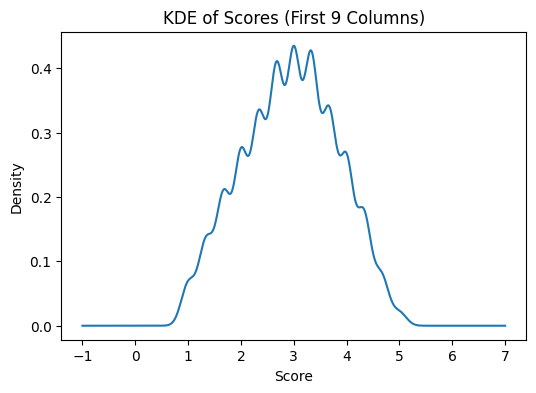

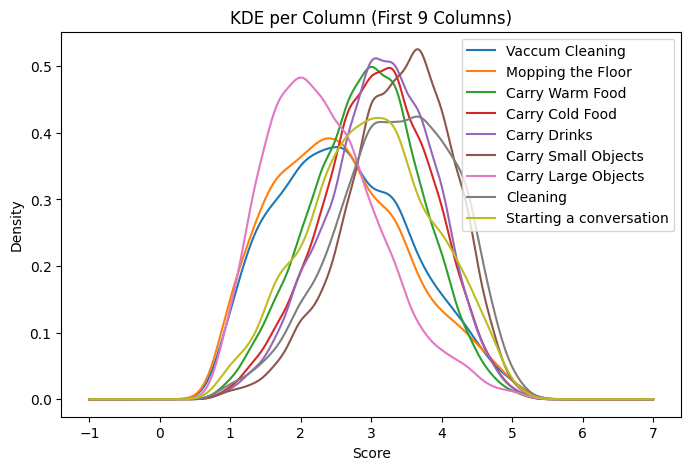

In [758]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: load your dataframe
# df = pd.read_csv("your_file.csv")
df = pd.read_pickle("../data/pepper_data_train.pkl")
# Select first 9 columns
scores = df.iloc[:, :9]

# Flatten into a single Series
all_scores = scores.values.flatten()

# Plot KDE
plt.figure(figsize=(6, 4))
pd.Series(all_scores).plot(kind="kde")
plt.xlabel("Score")
plt.title("KDE of Scores (First 9 Columns)")
plt.show()

import pandas as pd
import matplotlib.pyplot as plt

# Select first 9 columns
scores = df.iloc[:, :9]

plt.figure(figsize=(8, 5))

for col in scores.columns:
    scores[col].plot(kind="kde", label=col)

plt.xlabel("Score")
plt.title("KDE per Column (First 9 Columns)")
plt.legend()
plt.show()


In [726]:
df = pd.read_pickle("../data/pepper_data_test_equal.pkl")
df['filename'] = df['image_path'].str.split("/").str[-1]
tasks = list(df.columns[:9])
df_test = df[['filename']+ tasks]

In [727]:
# Merge dataframes on 'filename'
df_merged = pd.merge(df_all, df_test[['filename'] + tasks], on='filename', suffixes=('_annot', '_test'))

# Extract annotator scores and ground truth scores as numpy
annotator_scores_np = df_merged[[f'{t}_annot' for t in tasks]].values
ground_truth_np = df_merged[[f'{t}_test' for t in tasks]].values

mse, rmse, pcc, ccc = get_metrics(annotator_scores_np, ground_truth_np, rmse_scale_factor=1)
print(f"{pcc=}\n{ccc=}\n{rmse=}")


pcc=array(0.6029747, dtype=float32)
ccc=array(0.5332341, dtype=float32)
rmse=array(1.0371965, dtype=float32)


In [728]:
def get_perannotator_predictions(preds):
    df_merged = df_all.merge(df_test[['filename'] + tasks], on='filename', suffixes=('_annot', '_test'))
    df_preds = df_test[['filename']].copy()
    df_preds[tasks] = preds
    df_merged = df_merged.merge(df_preds, on='filename')

    annotator_scores_np = torch.from_numpy(df_merged[[f'{t}_annot' for t in tasks]].to_numpy(dtype='float32'))
    consensus_np = torch.from_numpy(df_merged[[f'{t}_test' for t in tasks]].to_numpy(dtype='float32'))
    preds_np = torch.from_numpy(df_merged[[t for t in tasks]].to_numpy(dtype='float32'))
    return annotator_scores_np, consensus_np, preds_np


In [739]:
# perplexity_preds[0]
# dualbranch_preds[0]
# lgr_preds[0]

annot, target, preds = get_perannotator_predictions(dualbranch_preds)
annot1, target1, preds1 = get_perannotator_predictions(lgr_preds)
print(get_metrics(annot, target1, rmse_scale_factor=1))
print(get_metrics(preds, target1, rmse_scale_factor=1))
get_stat_diff(preds1, preds, target)


(array(1.0757766, dtype=float32), array(1.0371965, dtype=float32), array(0.6029747, dtype=float32), array(0.5332341, dtype=float32))
(array(0.59463024, dtype=float32), array(0.7711227, dtype=float32), array(0.29467097, dtype=float32), array(0.2083363, dtype=float32))
Computing RMSE differences...


RMSE diff: 1.0657 95% CI [1.0230, 1.1028] p=0.0000 p1=0.0000
Computing PCC differences...
PCC diff: -0.1622 95% CI [-0.2326, -0.0914] p=0.0000 p1=0.0000
Computing CCC differences...
CCC diff: -0.1882 95% CI [-0.2596, -0.1159] p=0.0000 p1=0.0000


{'rmse': {'diff': 1.0656852722167969,
  'ci_lower_upper': (1.0229743361473083, 1.1027588099241257),
  'p_value': 0.0,
  'p_value_onesided': 0.0,
  'method': 'bootstrap_CI + permutation_p'},
 'pcc': {'diff': -0.16224344074726105,
  'ci_lower_upper': (-0.23256834956774017, -0.09138871604759471),
  'p_value': 7.052521747263896e-06,
  'p_value_onesided': 3.526260873631948e-06,
  'method': 'Steiger_p + Zou_CI'},
 'ccc': {'diff': -0.18817497976124287,
  'ci_lower_upper': (-0.25958068263134965, -0.11591869709860136),
  'p_value': 3.252075997384196e-07,
  'p_value_onesided': 1.626037998692098e-07,
  'method': 'Steiger_p + Zou_CI'}}

In [36]:
annotators = get_stat_diff(torch.from_numpy(annotator_scores_np), torch.from_numpy(preds_np), torch.from_numpy(consensus_np))

Computing RMSE differences...


RMSE diff: 0.2661 95% CI [0.2274, 0.3009] p=0.0000 p1=0.0000
Computing PCC differences...
PCC diff: 0.3083 95% CI [0.2392, 0.3778] p=0.0000 p1=0.0000
Computing CCC differences...
CCC diff: 0.3249 95% CI [0.2521, 0.3974] p=0.0000 p1=0.0000


In [ ]:
# with open('annotators_statsig.pkl', 'wb') as f:
#     pickle.dump(annotators, f)

In [33]:

mse, rmse, pcc, ccc = get_metrics(torch.from_numpy(annotator_scores_np), torch.from_numpy(consensus_np), rmse_scale_factor=1)
print(f"{pcc=}\n{ccc=}\n{rmse=}")

pcc=array(0.6029747, dtype=float32)
ccc=array(0.5332341, dtype=float32)
rmse=array(1.0371965, dtype=float32)


In [38]:
mse, rmse, pcc, ccc = get_metrics(torch.from_numpy(preds_np), torch.from_numpy(consensus_np), rmse_scale_factor=1)
print(f"{pcc=}\n{ccc=}\n{rmse=}")

pcc=array(0.29467097, dtype=float32)
ccc=array(0.2083363, dtype=float32)
rmse=array(0.7711227, dtype=float32)


### statistics

In [ ]:
import pickle

with open('ablationsES66.pkl', 'rb') as f:
    models66 = pickle.load(f)
with open('ablationsES42.pkl', 'rb') as f:
    models42 = pickle.load(f)
with open('ablationsESseeds.pkl', 'rb') as f:
    modelsseeds = pickle.load(f)

models_allseeds = {**models66, **models42, **modelsseeds}
_ = models_allseeds.pop('simple_base66')
# df = pd.concat([models66, models42, modelsseeds], ignore_index=True)

In [ ]:
rows=[]
mapping = {
    'PCC': 'pcc', 'CCC': 'ccc', 'RMSE': 'test_rmse',
    'ACC_Final': 'final_acc_rmse', 'ACC_Lesort': 'lesort_acc_rmse',
    'BWT_Lesort': 'lesort_bwt_rmse', 'FWT_Lesort': 'lesort_fwt_rmse'
}

rows = [
    {'model': name, **{k: metrics[v] for k, v in mapping.items() if v in metrics}}
    for name, metrics in models_allseeds.items()
]
df = pd.DataFrame(rows)

In [ ]:
df

In [ ]:
import pandas as pd
import numpy as np
import re
from scipy.stats import shapiro, ttest_rel, wilcoxon

df["Seed"] = df["model"].apply(lambda x: int(re.findall(r"\d+$", x)[0]))
def model_type(x):
    if "base" in x: return "base"
    elif "ablationnomask" in x: return "ablationnomask"
    elif "ablationonlysoc" in x: return "ablationonlysoc"
    elif "ablationonlyenv" in x: return "ablationonlyenv"
    else: return "other"
df["Type"] = df["model"].apply(model_type)

ablations = ["ablationnomask", "ablationonlysoc", "ablationonlyenv"]
metrics = ["RMSE", "CCC", "PCC", "ACC_Final", "ACC_Lesort", "BWT_Lesort", "FWT_Lesort"]
results = []

In [ ]:
df = df.drop(columns=['model'])

In [ ]:
import pandas as pd

metrics = ['RMSE', 'CCC', 'PCC', 'ACC_Final', 'ACC_Lesort', 'BWT_Lesort', 'FWT_Lesort']

# Separate base and ablation dataframes indexed by Seed
base_df = df[df['Type'] == 'base'].set_index('Seed')
ablation_df = df[df['Type'] != 'base'].set_index('Seed')

# Prepare a list to store difference DataFrames per ablation type
diff_list = []

# Iterate over each ablation type (excluding 'base')
ablation_types = df['Type'].unique()
ablation_types = [t for t in ablation_types if t != 'base']

for ab_type in ablation_types:
    ab_df = ablation_df[ablation_df['Type'] == ab_type]
    joined = ab_df[metrics].join(base_df[metrics], lsuffix='_ablation', rsuffix='_base', how='inner')

    # Calculate difference using values
    diff_values = joined[[f"{m}_ablation" for m in metrics]].values - joined[[f"{m}_base" for m in metrics]].values
    diff = pd.DataFrame(diff_values, columns=metrics, index=joined.index)
    
    # Add seed and type columns
    diff['Seed'] = diff.index
    diff['Type'] = ab_type
    
    diff_list.append(diff.reset_index(drop=True))

# Concatenate all differences for all ablation types
diff_df = pd.concat(diff_list, ignore_index=True)


In [ ]:
diff_df

In [ ]:
for ablation in ablations:
    base = df[df["Type"] == "base"].set_index("Seed")
    abl = df[df["Type"] == ablation].set_index("Seed")
    common_seeds = base.index.intersection(abl.index)
    for metric in metrics:
        base_vals = base.loc[common_seeds, metric].values
        abl_vals = abl.loc[common_seeds, metric].values
        diff = abl_vals - base_vals
        # Normality test
        shapiro_stat, shapiro_p = shapiro(diff)
        if shapiro_p > 0.05:
            stat, p = ttest_rel(abl_vals, base_vals)
            test_used = "Paired t-test"
        else:
            stat, p = wilcoxon(abl_vals, base_vals)
            test_used = "Wilcoxon"
        results.append({
            "Ablation": ablation,
            "Metric": metric,
            "Mean Difference": np.mean(diff),
            "Std Difference": np.std(diff),
            "p-value": p,
            "Test Used": test_used,
            "Normality p-value": shapiro_p
        })
results = pd.DataFrame(results)


In [ ]:
results

In [ ]:
import pandas as pd
import numpy as np

# Group by model type and metric calculate mean and std of each metric
metrics = ['RMSE', 'CCC', 'PCC', 'ACC_Final', 'ACC_Lesort', 'BWT_Lesort', 'FWT_Lesort']

# Calculate mean and std per Type (model group)
agg_funcs = {metric: ['mean', 'std'] for metric in metrics}
summary_stats = df.groupby('Type').agg(agg_funcs)

# Flatten multiindex columns
summary_stats.columns = [f'{m}_{stat}' for m, stat in summary_stats.columns]
summary_stats = summary_stats.reset_index()

# Rename for consistency
diff_df = results.rename(columns={
    'Ablation': 'Type',
    'Mean Difference': 'diff',
    'p-value': 'pval'
})

# Add significance flag
diff_df['significant'] = diff_df['pval'] < 0.05


# Merge summary stats with diff statistics on 'Type' and 'Metric'
merged_df = pd.merge(summary_stats.melt(id_vars='Type'),
                     diff_df,
                     left_on=['Type', 'variable'],
                     right_on=['Type', 'Metric'],
                     how='left')

# Rename melted columns
merged_df.rename(columns={'variable': 'Metric_Stat', 'value': 'Value'}, inplace=True)

merged_df[['Metric', 'Stat']] = merged_df['Metric_Stat'].str.rsplit('_', n=1, expand=True)

# Pivot mean and std values separately to keep numeric structure
mean_df = merged_df[merged_df['Stat'] == 'mean'].pivot(index='Type', columns='Metric', values='Value').add_suffix('_mean')
std_df = merged_df[merged_df['Stat'] == 'std'].pivot(index='Type', columns='Metric', values='Value').add_suffix('_std')

# For diff, pval, significant - take unique rows per Type and Metric
diff_only = diff_df.set_index(['Type', 'Metric'])[['diff', 'pval', 'significant']].unstack(level=1)
# Flatten MultiIndex columns from diff_only
diff_only.columns = ['_'.join(col).strip() for col in diff_only.columns.values]

# Combine all
final_table = pd.concat([mean_df, std_df, diff_only], axis=1).reset_index()

# Fill diff/pval/significant NaNs with appropriate values (e.g. 0, 1, False) for base models
final_table.fillna({'diff_RMSE': 0, 'pval_RMSE': 1, 'significant_RMSE': False}, inplace=True)
# (fill all pval, diff, sig similarly or customize per metric)


In [ ]:
final_table[['Type', 'RMSE_mean', 'diff_RMSE']]

In [ ]:
summary_stats

### perplexity

In [535]:
df_preds = pd.read_csv('../data/perplexity_predicted_scores.csv')
test_df = pd.read_pickle("../data/pepper_data_test_equal.pkl")
tasks = list(test_df.columns)[:9]
df_labels = test_df[['image_path']+tasks]
df_preds = df_preds.set_index('image_path')
df_labels = df_labels.set_index('image_path')

In [536]:
assert set(df_preds.index) == set(df_labels.index), "Mismatch in image_path indices!"
df_labels_aligned = df_labels.reindex(df_preds.index)


In [ ]:
labels_array = df_labels_aligned.to_numpy(dtype='float32')
preds_array = torch.from_numpy(df_preds.to_numpy(dtype='float32'))

In [537]:
perplexity_preds = torch.from_numpy(df_preds.to_numpy(dtype='float32'))

In [44]:
mse, rmse, pcc,ccc = get_metrics(preds_array, labels_array, rmse_scale_factor=1)
print(f"{pcc=}\n{ccc=}\n{rmse=}")

pcc=array(0.06702608, dtype=float32)
ccc=array(0.03579658, dtype=float32)
rmse=array(1.0379657, dtype=float32)


In [50]:
perplexity_stat = get_stat_diff(torch.from_numpy(preds_array), dualbranch_preds, targets)

Computing RMSE differences...


RMSE diff: 0.2610 95% CI [0.2186, 0.3021] p=0.0000 p1=0.0000
Computing PCC differences...
PCC diff: -0.2184 95% CI [-0.3617, -0.0718] p=0.0035 p1=0.0018
Computing CCC differences...
CCC diff: -0.1651 95% CI [-0.3112, -0.0161] p=0.0299 p1=0.0149


In [ ]:
# with open('perplexity_statsig.pkl', 'wb') as f:
#     pickle.dump(perplexity_stat, f)

### LGR

In [1]:
import pickle

with open('10_30_10_True_history.pkl', 'rb') as f:
    history = pickle.load(f)

In [ ]:
import torch.nn as nn
from torchvision import models
import torch


class FCNet(nn.Module):
	def __init__(self, num_classes):
		super(FCNet, self).__init__()
		self.fc1_bn = nn.BatchNorm1d(1280)
		self.fc2 = nn.Linear(1280, 32)
		# self.fc2_bn = nn.BatchNorm1d(128)
		# self.fc3 = nn.Linear(128, 32)
		self.fc4 = nn.Linear(32, num_classes)
	
	def forward(self, x):
		x = self.fc1_bn(x)
		x = self.fc2(x)
		# x = self.fc2_bn(x)
		# x = self.fc3(x)
		x = self.fc4(x)
		
		return x


class conv(nn.Module):
	def __init__(self):
		super(conv, self).__init__()
		self.conv1 = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1).features
		self.fc1 = nn.AdaptiveAvgPool2d((1, 1))

		self.fc1_f = nn.Flatten()
	
	def forward(self, x):
		x = self.conv1(x)
		x = self.fc1(x)
		x = self.fc1_f(x)
		return x

# Define the complete Net class with both submodules
class Net(nn.Module):
	def __init__(self):
		super(Net, self).__init__()
		self.conv_module = conv()
		self.fc_module = FCNet(num_classes=9)
	
	def forward(self, x):
		x = self.conv_module(x)
		x = self.fc_module(x)
		return {
				'output': x,
		}

In [ ]:
test_df = pd.read_pickle("../data/pepper_data_test_equal.pkl")
dataloader = get_ablation_dataloader('nomask', include_test=test_df)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net() 
state_dict = torch.load('../../FedLGR_SocRob/models/ver2/fullmod9.pth', map_location='cpu')
model.load_state_dict(state_dict)
model = model.to(device)
# domain_preds_targets = infer_per_domain(model, device, dataloader, 'test')
# preds, targets = aggregate_domain_data(domain_preds_targets)
preds, targets = infer(model, device, dataloader, 'test')

In [ ]:
model=Net()
model2=Net()
state_dict = torch.load(f'../../FedLGR_SocRob/models/ver2/fullmod9.pth', map_location='cpu')
model.load_state_dict(state_dict)
# state_dict = torch.load(f'../../FedLGR_SocRob/models/ver2/fullmod9.pth', map_location='cpu')
# conv_weights = {k[len('conv_module.'):]: v for k, v in state_dict.items() if k.startswith('conv_module.')}
# model.conv_module.load_state_dict(conv_weights)
# load_classifier_weights(f"../../FedLGR_SocRob/models/ver2/mod0.pkl", model)

state_dict = torch.load(f'../../FedLGR_SocRob/models/ver2/fullmod9.pth', map_location='cpu')
model2.load_state_dict(state_dict)
# load_classifier_weights(f"../../FedLGR_SocRob/models/ver2/mod8.pkl", model2)

test_df = pd.read_pickle("../data/pepper_data_test_equal.pkl")
dataloader = get_ablation_dataloader('nomask', include_test=test_df)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model2 = model2.to(device)
preds, targets = infer(model, device, dataloader, 'test')
mse, rmse, pcc,ccc = get_metrics(preds, targets)
print(f"f'ver2/fullmod0.pth'\n\t{pcc=}\nt\t{ccc=}\n\t{rmse=}\n\t{mse=}")
preds, targets = infer(model2, device, dataloader, 'test')
mse, rmse, pcc,ccc = get_metrics(preds, targets)
print(f"f'ver2/fullmod0.pth'\n\t{pcc=}\nt\t{ccc=}\n\t{rmse=}\n\t{mse=}")

In [ ]:
def load_classifier_weights(path, model):
    with open(path, "rb") as f:
        weights_list = pickle.load(f)
    keys = list(model.fc_module.state_dict().keys())
    state_dict = {k: torch.tensor(v) for k, v in zip(keys, weights_list)}
    model.fc_module.load_state_dict(state_dict)

In [ ]:
def infer_lgr(fullmod=None, fc_mod=None):
    test_df = pd.read_pickle("../data/pepper_data_test_equal.pkl")
    dataloader = get_ablation_dataloader('nomask', include_test=test_df)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Net()
    state_dict = torch.load(f'../../FedLGR_SocRob/models/{fullmod}', map_location='cpu')
    model.load_state_dict(state_dict)
    if fc_mod is not None:
        load_classifier_weights(f"../../FedLGR_SocRob/models/{fc_mod}", model)
    model = model.to(device)
    domain_preds_targets = infer_per_domain(model, device, dataloader, 'test')
    preds, targets = aggregate_domain_data(domain_preds_targets)
    
    return preds, targets
    

In [ ]:
preds, targets = infer_lgr('ver2/fullmod0.pth', 'ver2/mod9.pkl')

In [ ]:
all_preds=[]
all_targets=[]
for i in range(10):
    preds, targets = infer_lgr('ver2/fullmod0.pth', f'ver2/mod{i}.pkl')
    all_preds.append(preds)
    all_targets.append(targets)
all_preds = torch.stack(all_preds).mean(dim=0)
all_targets = torch.stack(all_targets).mean(dim=0)

In [ ]:
preds, targets = infer_lgr('ver2/fullmod0.pth')


In [ ]:
data={
    'fullmod': (preds.cpu().numpy(), targets.cpu().numpy()),
    'fullmod_mod_average_client': (all_preds.cpu().numpy(), all_targets.cpu().numpy())
}


In [ ]:
mse, rmse, pcc,ccc = get_metrics(preds, targets)
print(f"\t{pcc=}\n\t{ccc=}\n\t{rmse=}\n\t{mse=}")

In [ ]:
mse, rmse, pcc,ccc = get_metrics(all_preds, all_targets)
print(f"\t{pcc=}\n\t{ccc=}\n\t{rmse=}\n\t{mse=}")

In [2]:
rounds_to_extract = {5, 10, 15, 20, 25, 30}

extracted = [
    [val for (round_num, val) in lst if round_num in rounds_to_extract]
    for key, lst in history.metrics_distributed.items()
]

In [3]:

flipped = [list(x) for x in zip(*extracted[2:])]
flipped

[[9.18544864654541,
  10.142410596211752,
  10.444842338562012,
  9.498682657877604,
  8.19070831934611,
  10.013394037882486],
 [9.084603309631348,
  9.72533893585205,
  10.288761774698893,
  9.531467119852701,
  8.423773606618246,
  9.47169272104899],
 [9.233560562133789,
  9.771426836649576,
  10.268208821614584,
  9.56922435760498,
  8.388973395029703,
  9.847820917765299],
 [9.158552169799805,
  9.429169336954752,
  9.96381409962972,
  9.078171412150065,
  8.258100986480713,
  9.668341000874838],
 [9.006463050842285,
  10.030258496602377,
  10.344561894734701,
  9.515462557474772,
  8.016562620798746,
  9.310345649719238],
 [9.154163678487143,
  9.57750670115153,
  10.574878056844076,
  9.715548197428385,
  8.16542704900106,
  9.552376429239908]]

In [4]:
cross_dom = [{i:j for i,j in enumerate(l)} for l in flipped]

In [5]:
cross_dom

[{0: 9.18544864654541,
  1: 10.142410596211752,
  2: 10.444842338562012,
  3: 9.498682657877604,
  4: 8.19070831934611,
  5: 10.013394037882486},
 {0: 9.084603309631348,
  1: 9.72533893585205,
  2: 10.288761774698893,
  3: 9.531467119852701,
  4: 8.423773606618246,
  5: 9.47169272104899},
 {0: 9.233560562133789,
  1: 9.771426836649576,
  2: 10.268208821614584,
  3: 9.56922435760498,
  4: 8.388973395029703,
  5: 9.847820917765299},
 {0: 9.158552169799805,
  1: 9.429169336954752,
  2: 9.96381409962972,
  3: 9.078171412150065,
  4: 8.258100986480713,
  5: 9.668341000874838},
 {0: 9.006463050842285,
  1: 10.030258496602377,
  2: 10.344561894734701,
  3: 9.515462557474772,
  4: 8.016562620798746,
  5: 9.310345649719238},
 {0: 9.154163678487143,
  1: 9.57750670115153,
  2: 10.574878056844076,
  3: 9.715548197428385,
  4: 8.16542704900106,
  5: 9.552376429239908}]

In [24]:
get_cl_matrix(cross_dom)

array([[ 9.18544865, 10.1424106 , 10.44484234,  9.49868266,  8.19070832,
        10.01339404],
       [ 9.08460331,  9.72533894, 10.28876177,  9.53146712,  8.42377361,
         9.47169272],
       [ 9.23356056,  9.77142684, 10.26820882,  9.56922436,  8.3889734 ,
         9.84782092],
       [ 9.15855217,  9.42916934,  9.9638141 ,  9.07817141,  8.25810099,
         9.668341  ],
       [ 9.00646305, 10.0302585 , 10.34456189,  9.51546256,  8.01656262,
         9.31034565],
       [ 9.15416368,  9.5775067 , 10.57487806,  9.7155482 ,  8.16542705,
         9.55237643]])

In [25]:
metrics = {}
metrics['pcc'] = -0.0234 #from the output csv file
metrics['test_rmse'] = extracted[1][5] #avg_rmse on final task is tested on agregate test set
metrics['cl_matrix_mse'] = get_cl_matrix(cross_dom)
metrics['cross_dom_rmse'] = convert_rmse_cross_domain(cross_dom)
metrics['cl_matrix_rmse'] = get_cl_matrix(metrics['cross_dom_rmse'])
metrics['final_acc_rmse'] = math.sqrt(final_acc(metrics['cl_matrix_mse']))
metrics['lesort_acc_rmse'] = math.sqrt(lesort_acc(metrics['cl_matrix_mse']))
metrics['lesort_fwt_rmse'] = math.sqrt(lesort_fwt(metrics['cl_matrix_mse']))
metrics['lesort_bwt_rmse'] = lesort_bwt(metrics['cl_matrix_rmse'])

In [26]:
rows = []
rows.append({
    'Model': 'LGR',
    'PCC': metrics['pcc'],
    'CCC': None,
    'RMSE': metrics['test_rmse'],
    # 'mean domain RMSE': math.sqrt(dict_mean(history['test_cross_domain_val_mse'])) *4,
    
    #LESORT CL METRICS are calculated on cross domain validations collected DURING training
    'Acc_Final': metrics['final_acc_rmse'],
    'ACC_Lesort': metrics['lesort_acc_rmse'],
    'BWT_Lesort': metrics['lesort_bwt_rmse'],
    'FWT_Lesort': metrics['lesort_fwt_rmse'],
})
df_lgr = pd.DataFrame(rows)

In [27]:
df_lgr

,Model,PCC,CCC,RMSE,Acc_Final,ACC_Lesort,BWT_Lesort,FWT_Lesort
0,LGR,-0.0234,None,3.081302,3.075167,3.074871,0.039895,3.06647


In [ ]:
db = df.head(1)

In [ ]:
db

In [ ]:
f = pd.concat([db, df_lgr]).reset_index(drop=True)

In [ ]:
f.to_dict()

### stat diff DualBranch vs LGR

In [779]:
with open('ablationsES42.pkl', 'rb') as f:
    m = pickle.load(f)
dualbranch = m['mobilenetv2_base42']['test_preds_targets']
dualbranch_preds = torch.from_numpy(dualbranch[0])*4+1

In [786]:
with open('lgr_preds_targets.pkl', 'rb') as f:
    m = pickle.load(f)
lgr = m['fullmod_mod_average_client']
lgr_preds = torch.from_numpy(lgr[0])

In [776]:
test_df = pd.read_pickle("../data/pepper_data_test_equal.pkl")
og_targets = test_df[test_df.columns[:9]].to_numpy(dtype='float32')
targets = og_targets
targets = torch.from_numpy(targets)

In [733]:
print(dualbranch_preds[0])
print(lgr_preds[0])
print(targets[0])

tensor([1.948, 1.943, 2.098, 2.341, 2.537, 2.771, 1.998, 2.641, 2.787])
tensor([1.151, 0.996, 1.272, 1.449, 1.465, 1.524, 1.044, 1.324, 1.119])
tensor([1.333, 1.333, 1.333, 1.667, 1.333, 1.667, 1.000, 1.667, 2.000])


In [23]:
mse, rmse, pcc,ccc = get_metrics(dualbranch_preds, targets, rmse_scale_factor=1)
print(f"db\n\t{pcc.round(3)=}\n\t{ccc.round(3)=}\n\t{rmse.round(3)=}\n\t{mse.round(3)=}")

db
	pcc.round(3)=np.float32(0.285)
	ccc.round(3)=np.float32(0.201)
	rmse.round(3)=np.float32(0.777)
	mse.round(3)=np.float32(0.604)


In [515]:
mse, rmse, pcc,ccc = get_metrics(dualbranch_preds, targets, rmse_scale_factor=1, agg=False)
print(f"db\n\t{mse.round(3)=}\n\t{rmse.round(3)=}\n\t{pcc.round(3)=}")

db
	mse.round(3)=array([0.685, 0.677, 0.542, 0.534, 0.587, 0.468, 0.699, 0.579, 0.661],
      dtype=float32)
	rmse.round(3)=array([0.827, 0.823, 0.736, 0.731, 0.766, 0.684, 0.836, 0.761, 0.813],
      dtype=float32)
	pcc.round(3)=array([0.403, 0.449, 0.213, 0.226, 0.203, 0.305, 0.328, 0.341, 0.069],
      dtype=float32)


In [37]:
dualbranch_preds = dualbranch_preds.to('cpu')
lgr_preds = lgr_preds.to('cpu')
targets = targets.to('cpu')
mse, rmse, pcc,ccc = get_metrics(dualbranch_preds, targets, rmse_scale_factor=1)
print(f"db\n\t{pcc=}\n\t{ccc=}\n\t{rmse=}\n\t{mse=}")
mse1, rmse1, pcc1,ccc1 = get_metrics(lgr_preds, targets, rmse_scale_factor=1)
print(f"lgr\n\t{pcc1=}\n\t{ccc1=}\n\t{rmse1=}\n\t{mse1=}")
print(mse1-mse, rmse1-rmse, pcc1-pcc, ccc1-ccc)

db
	pcc=array(0.2854368, dtype=float32)
	ccc=array(0.20086385, dtype=float32)
	rmse=array(0.77692944, dtype=float32)
	mse=array(0.60361934, dtype=float32)
lgr
	pcc1=array(0.11777555, dtype=float32)
	ccc1=array(0.01838993, dtype=float32)
	rmse1=array(1.8323, dtype=float32)
	mse1=array(3.3573232, dtype=float32)
2.7537038 1.0553706 -0.16766125 -0.18247393


In [71]:
with open('ablationsES42.pkl', 'rb') as f:
    models42 = pickle.load(f)
ablations = {
    'nomask_pred': torch.from_numpy(models42['mobilenetv2_ablationnomask42']['test_preds_targets'][0])*4+1,
    'onlyenv_pred': torch.from_numpy(models42['mobilenetv2_ablationonlyenv42']['test_preds_targets'][0])*4+1,
    'onlysoc_pred': torch.from_numpy(models42['mobilenetv2_ablationonlysoc42']['test_preds_targets'][0])*4+1,
}


In [ ]:
for k,v in ablations.item():
    print(k, v[0])

In [90]:
with open('perturbations.pkl', 'rb') as f:
    perturba = pickle.load(f)
occlusions = {k.split('.')[1]: torch.from_numpy(v['test_preds_targets'][0])*4+1 for k,v in perturba.items()}

In [61]:
with open('upperlowerbound.pkl', 'rb') as f:
    b = pickle.load(f)
bounds = {
    'basenobuffer': torch.from_numpy(b['mobilenetv2_basenobuffer']['test_preds_targets'][0])*4+1,
    'basenocl': torch.from_numpy(b['mobilenetv2_basenocl']['test_preds_targets'][0])*4+1,
    'base': torch.from_numpy(b['mobilenetv2_base']['test_preds_targets'][0])*4+1,
}

In [735]:
import numpy as np
import torch
from corrstats import dependent_corr
from tqdm import tqdm

# --- RMSE calculation across all samples and tasks ---
def rmse(preds: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    mse_loss = nn.MSELoss()
    mse = mse_loss(preds, targets)
    return torch.sqrt(mse)

# --- Fisher z transform pooling of 9 per-task values ---
def pooled_fisher_z(values: torch.Tensor) -> torch.Tensor:
    z = torch.atanh(values)
    mean_z = z.mean()
    return torch.tanh(mean_z)

# --- Compute pooled metric (PCC or CCC) over tasks ---
def compute_pooled_metric(metric_fn, preds, targets) -> torch.Tensor:
    results = []
    for i in range(preds.shape[1]):
        # metric_fn expects shape (N,), single task column
        val = metric_fn(preds[:, i], targets[:, i])
        results.append(val)
    results = torch.stack(results)
    pooled = pooled_fisher_z(results)
    return pooled

# --- RMSE-specific bootstrap CI difference ---
def bootstrap_ci_diff_rmse(preds1, preds2, targets,
                           n_boot=1000, device='cuda'):
    preds1 = preds1.to(device)
    preds2 = preds2.to(device)
    targets = targets.to(device)
    n = preds1.shape[0]
    diffs = []
    for _ in tqdm(range(n_boot), leave=False):
        idx = torch.randint(0, n, (n,), device=device)
        rmse1 = rmse(preds1[idx], targets[idx])
        rmse2 = rmse(preds2[idx], targets[idx])
        diffs.append((rmse1 - rmse2).cpu().item())
    ci_lower = np.percentile(diffs, 2.5)
    ci_upper = np.percentile(diffs, 97.5)
    return ci_lower.item(), ci_upper.item()

# --- RMSE-specific permutation test ---
def permutation_test_diff_rmse(preds1, preds2, targets,
                               n_perm=1000, device='cuda'):
    preds1 = preds1.to(device)
    preds2 = preds2.to(device)
    targets = targets.to(device)
    n = preds1.shape[0]
    obs_diff = (rmse(preds1, targets) - rmse(preds2, targets)).cpu().item()
    diffs = []
    for _ in tqdm(range(n_perm), leave=False):
        swap_mask = torch.rand(n, device=device) < 0.5
        perm_preds1 = preds1.clone()
        perm_preds2 = preds2.clone()
        perm_preds1[swap_mask], perm_preds2[swap_mask] = preds2[swap_mask], preds1[swap_mask]
        diff = (rmse(perm_preds1, targets) - rmse(perm_preds2, targets)).cpu().item()
        diffs.append(diff)
    diffs = np.array(diffs)
    p_value = np.mean(np.abs(diffs) >= np.abs(obs_diff))
    # One-sided p-value: Test if Model 2 is significantly better (lower RMSE)
    # This tests: H0: RMSE1 <= RMSE2 vs H1: RMSE1 > RMSE2
    # Model 2 better means obs_diff > 0 (RMSE1 - RMSE2 > 0)
    p_value_one_sided = np.mean(diffs >= obs_diff)
    return obs_diff, p_value.item(), p_value_one_sided.item()


def compute_correlation_difference_analytical(metric_fn, preds1, preds2, targets, alpha=0.05):
    """
    Use corrstats.py dependent_corr for analytical p-value and CI calculation.
    """
    # Compute pooled correlations
    pooled1 = compute_pooled_metric(metric_fn, preds1, targets).cpu().item()
    pooled2 = compute_pooled_metric(metric_fn, preds2, targets).cpu().item()
    
    # Compute correlation between model predictions (for dependency correction)
    r_preds = torch.corrcoef(torch.stack([preds1.flatten(), preds2.flatten()]))[0, 1].cpu().item()
    
    n = preds1.shape[0]
    
    # Use Steiger method for two-sided p-value
    t_stat, p_two_sided = dependent_corr(pooled1, pooled2, r_preds, n, 
                                       twotailed=True, method='steiger')
    
    # Simple conversion to one-sided
    p_one_sided = p_two_sided / 2
    
    # Use Zou method for confidence interval
    ci_lower, ci_upper = dependent_corr(pooled1, pooled2, r_preds, n, 
                                      conf_level=1-alpha, method='zou')
    
    difference = pooled1 - pooled2
    
    return difference, (ci_lower, ci_upper), p_two_sided.item(), p_one_sided.item()

from torchmetrics import PearsonCorrCoef, ConcordanceCorrCoef

device = 'cuda' if torch.cuda.is_available() else 'cpu'

pcc_metric = PearsonCorrCoef(num_outputs=1).to(device)
ccc_metric = ConcordanceCorrCoef(num_outputs=1).to(device)
def torch_pcc(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    pcc_metric.reset()
    x = x.to(device)
    y = y.to(device)
    return pcc_metric(x.unsqueeze(1), y.unsqueeze(1))

def torch_ccc(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    ccc_metric.reset()
    x = x.to(device)
    y = y.to(device)
    return ccc_metric(x.unsqueeze(1), y.unsqueeze(1))

def get_stat_diff(preds_model1, preds_model2, targets):
    """
    Improved version using corrstats.py for correlations, permutation for RMSE.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    preds1 = preds_model1.to(device)
    preds2 = preds_model2.to(device)
    targets = targets.to(device)
    
    results = {}
    
    # === RMSE: Keep your current approach ===
    print("Computing RMSE differences...")
    ci_lower, ci_upper = bootstrap_ci_diff_rmse(preds1, preds2, targets)
    obs_diff, p_value, p_value_onesided = permutation_test_diff_rmse(preds1, preds2, targets)
    
    results['rmse'] = {
        'diff': obs_diff,
        'ci_lower_upper': (ci_lower, ci_upper),
        'p_value': p_value,
        'p_value_onesided': p_value_onesided,
        'method': 'bootstrap_CI + permutation_p'
    }
    print(f'RMSE diff: {obs_diff:.4f} 95% CI [{ci_lower:.4f}, {ci_upper:.4f}] p={p_value:.4f} p1={p_value_onesided:.4f}')
    
    # === PCC: Use analytical method ===
    print("Computing PCC differences...")
    diff, (ci_lower, ci_upper), p_value, p_value_onesided = compute_correlation_difference_analytical(
        torch_pcc, preds1, preds2, targets)
    
    results['pcc'] = {
        'diff': diff,
        'ci_lower_upper': (ci_lower, ci_upper),
        'p_value': p_value,
        'p_value_onesided': p_value_onesided,
        'method': 'Steiger_p + Zou_CI'
    }
    print(f'PCC diff: {diff:.4f} 95% CI [{ci_lower:.4f}, {ci_upper:.4f}] p={p_value:.4f} p1={p_value_onesided:.4f}')
    
    # === CCC: Use analytical method ===
    print("Computing CCC differences...")
    diff, (ci_lower, ci_upper), p_value, p_value_onesided = compute_correlation_difference_analytical(
        torch_ccc, preds1, preds2, targets)
    
    results['ccc'] = {
        'diff': diff,
        'ci_lower_upper': (ci_lower, ci_upper),
        'p_value': p_value,
        'p_value_onesided': p_value_onesided,
        'method': 'Steiger_p + Zou_CI'
    }
    print(f'CCC diff: {diff:.4f} 95% CI [{ci_lower:.4f}, {ci_upper:.4f}] p={p_value:.4f} p1={p_value_onesided:.4f}')
    
    return results

In [83]:

# ablations_stats={}
# for name,ablation_preds in ablations.items():
#     ablations_stats[name] = get_stat_diff(ablation_preds, dualbranch_preds, targets, device)

print([x.round(3) for x in get_metrics(dualbranch_preds, targets, rmse_scale_factor=1)])
for name,ablation_preds in ablations.items():
    print(name)
    print([x.round(3) for x in get_metrics(ablation_preds, targets, rmse_scale_factor=1)])

[np.float32(0.604), np.float32(0.777), np.float32(0.285), np.float32(0.201)]
nomask_pred
[np.float32(0.595), np.float32(0.771), np.float32(0.25), np.float32(0.168)]
onlyenv_pred
[np.float32(0.614), np.float32(0.783), np.float32(0.239), np.float32(0.139)]
onlysoc_pred
[np.float32(0.701), np.float32(0.837), np.float32(-0.028), np.float32(-0.002)]


In [96]:
# occlusions_stats = {}
# for k,occlusion_pred in occlusions.items():
#     print(k)
#     occlusions_stats[k] = get_stat_diff(occlusion_pred, dualbranch_preds, targets, device)

print([x.round(3) for x in get_metrics(dualbranch_preds, targets, rmse_scale_factor=1)])
for name,occlusion_pred in occlusions.items():
    print(name)
    print([x.round(3) for x in get_metrics(occlusion_pred, targets, rmse_scale_factor=1)])

[np.float32(0.604), np.float32(0.777), np.float32(0.285), np.float32(0.201)]
env
[np.float32(0.619), np.float32(0.787), np.float32(0.264), np.float32(0.161)]
socnorobot
[np.float32(0.619), np.float32(0.787), np.float32(0.255), np.float32(0.178)]
socnoppl
[np.float32(1.223), np.float32(1.106), np.float32(0.164), np.float32(0.072)]
nosoc
[np.float32(1.064), np.float32(1.031), np.float32(0.137), np.float32(0.079)]
noenv
[np.float32(0.647), np.float32(0.804), np.float32(0.207), np.float32(0.167)]


In [112]:
# bounds_stats = {}
# for k,bounds_pred in bounds.items():
#     print(k)
#     bounds_stats[k] = get_stat_diff(bounds_pred, dualbranch_preds, targets, device)

print([x.round(3) for x in get_metrics(dualbranch_preds, targets, rmse_scale_factor=1)])
for name,bounds_pred in bounds.items():
    print(name)
    print([x.round(3) for x in get_metrics(bounds_pred, targets, rmse_scale_factor=1)])

[np.float32(0.604), np.float32(0.777), np.float32(0.285), np.float32(0.201)]
basenobuffer
[np.float32(0.737), np.float32(0.858), np.float32(0.161), np.float32(0.098)]
basenocl
[np.float32(0.575), np.float32(0.758), np.float32(0.267), np.float32(0.168)]
base
[np.float32(0.604), np.float32(0.777), np.float32(0.285), np.float32(0.201)]


In [509]:
get_metrics(dualbranch_preds,targets, rmse_scale_factor=1, corr_out=9, agg=False)

(array([0.6847374 , 0.6774919 , 0.5417872 , 0.53395516, 0.5869585 ,
        0.46831417, 0.69894195, 0.5792317 , 0.6611556 ], dtype=float32),
 array([0.8274886 , 0.82309896, 0.73606193, 0.73072237, 0.7661322 ,
        0.6843348 , 0.8360275 , 0.7610727 , 0.81311476], dtype=float32),
 array([0.40275148, 0.44890338, 0.21320221, 0.22639991, 0.2028385 ,
        0.30496246, 0.32771012, 0.3409637 , 0.06892519], dtype=float32),
 array([0.3089559 , 0.33176926, 0.16525327, 0.16894904, 0.14049943,
        0.20722315, 0.18809848, 0.25240505, 0.03106177], dtype=float32))

In [645]:
from torchmetrics import PearsonCorrCoef, ConcordanceCorrCoef

device = 'cuda' if torch.cuda.is_available() else 'cpu'

pcc_metric = PearsonCorrCoef(num_outputs=1).to(device)
ccc_metric = ConcordanceCorrCoef(num_outputs=1).to(device)

def torch_pcc(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    pcc_metric.reset()
    x = x.to(device)
    y = y.to(device)
    return pcc_metric(x.unsqueeze(1), y.unsqueeze(1))

def torch_ccc(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    ccc_metric.reset()
    x = x.to(device)
    y = y.to(device)
    return ccc_metric(x.unsqueeze(1), y.unsqueeze(1))

def pooled_fisher_z(values: torch.Tensor) -> torch.Tensor:
    z = torch.atanh(values)
    mean_z = z.mean()
    return torch.tanh(mean_z)

def compute_pooled_metric(metric_fn, preds, targets) -> torch.Tensor:
    results = []
    for i in range(preds.shape[1]):
        val = metric_fn(preds[:, i], targets[:, i])
        results.append(val)
    results = torch.stack(results)
    pooled = pooled_fisher_z(results)
    return pooled

def compute_taskgroup_correlation_difference(metric_fn, preds, targets, group1_indices, group2_indices, alpha=0.05):
    # Slice preds and targets
    preds_group1 = preds[:, group1_indices]
    preds_group2 = preds[:, group2_indices]
    targets_group1 = targets[:, group1_indices]
    targets_group2 = targets[:, group2_indices]
    
    # Compute pooled metric
    pooled1 = compute_pooled_metric(metric_fn, preds_group1, targets_group1).cpu().item()
    pooled2 = compute_pooled_metric(metric_fn, preds_group2, targets_group2).cpu().item()
    
    # Aggregate predictions within each group (e.g., mean per sample)
    # This is a crucial change: we want one value per sample per group
    preds_agg_group1 = preds_group1.mean(dim=1)
    preds_agg_group2 = preds_group2.mean(dim=1)
    
    # Correlation between aggregated predictions (not flattened)
    # This is the r_preds for dependent_corr, which matches the methodology in the literature
    r_preds = torch.corrcoef(torch.stack([preds_agg_group1, preds_agg_group2]))[0, 1].cpu().item()
    
    n = preds.shape[0]
    
    t_stat, p_two_sided = dependent_corr(pooled1, pooled2, r_preds, n, twotailed=True, method='steiger')
    p_one_sided = p_two_sided / 2
    ci_lower, ci_upper = dependent_corr(pooled1, pooled2, r_preds, n, conf_level=1-alpha, method='zou')
    difference = pooled1 - pooled2
    
    return {
        'diff': difference,
        'ci_lower_upper': (ci_lower, ci_upper),
        'p_value_two_sided': p_two_sided,
        'p_value_one_sided': p_one_sided,
        'method': 'Steiger_p + Zou_CI'
    }

results_pcc = compute_taskgroup_correlation_difference(
    torch_pcc, lgr_preds, targets, [2,3,4,8], [0,1,5,6,7])
results_ccc = compute_taskgroup_correlation_difference(
    torch_ccc, lgr_preds, targets, [2,3,4,8], [0,1,5,6,7])


print("PCC group difference:", results_pcc)
print("CCC group difference:", results_ccc)



PCC group difference: {'diff': -0.12988318130373955, 'ci_lower_upper': (-0.2205683528612641, -0.03796954599003914), 'p_value_two_sided': np.float64(0.005434193538755183), 'p_value_one_sided': np.float64(0.0027170967693775916), 'method': 'Steiger_p + Zou_CI'}
CCC group difference: {'diff': -0.023481132928282022, 'ci_lower_upper': (-0.11567369128527363, 0.06898476425662312), 'p_value_two_sided': np.float64(0.6203879540252322), 'p_value_one_sided': np.float64(0.3101939770126161), 'method': 'Steiger_p + Zou_CI'}


In [648]:
import torch
import numpy as np
from tqdm import tqdm

def group_rmse_per_sample(preds: torch.Tensor, targets: torch.Tensor, group_indices: list) -> torch.Tensor:
    """Compute RMSE per sample for the specified task group."""
    preds_group = preds[:, group_indices]
    targets_group = targets[:, group_indices]
    return torch.sqrt(torch.mean((preds_group - targets_group)**2, dim=1))

def bootstrap_ci_diff_rmse_groups(preds, targets, group1_indices, group2_indices, n_boot=1000, device='cpu'):
    """Bootstrap 95% CI for the difference in mean RMSE between groups."""
    rmse_group1 = group_rmse_per_sample(preds, targets, group1_indices).to(device)
    rmse_group2 = group_rmse_per_sample(preds, targets, group2_indices).to(device)
    obs_diff = (rmse_group1.mean() - rmse_group2.mean()).item()
    n = rmse_group1.shape[0]
    diffs = []
    for _ in tqdm(range(n_boot), leave=False):
        idx = torch.randint(0, n, (n,), device=device)
        mean1 = rmse_group1[idx].mean()
        mean2 = rmse_group2[idx].mean()
        diffs.append((mean1 - mean2).item())
    ci_lower = np.percentile(diffs, 2.5)
    ci_upper = np.percentile(diffs, 97.5)
    return obs_diff, (ci_lower, ci_upper)

def permutation_test_diff_rmse_groups(preds, targets, group1_indices, group2_indices, n_perm=1000, device='cpu'):
    """Permutation test for the difference in mean RMSE between groups."""
    rmse_group1 = group_rmse_per_sample(preds, targets, group1_indices).to(device)
    rmse_group2 = group_rmse_per_sample(preds, targets, group2_indices).to(device)
    obs_diff = (rmse_group1.mean() - rmse_group2.mean()).item()
    n = rmse_group1.shape[0]
    diffs = []
    for _ in tqdm(range(n_perm), leave=False):
        swap_mask = torch.rand(n, device=device) < 0.5
        rmse_perm1 = torch.where(swap_mask, rmse_group1, rmse_group2)
        rmse_perm2 = torch.where(swap_mask, rmse_group2, rmse_group1)
        diff = (rmse_perm1.mean() - rmse_perm2.mean()).item()
        diffs.append(diff)
    diffs = np.array(diffs)
    p_value = np.mean(np.abs(diffs) >= np.abs(obs_diff))
    p_value_one_sided = np.mean(diffs >= obs_diff)
    return obs_diff, p_value, p_value_one_sided

def compute_rmse_groups_stat_diff(preds, targets, group1_indices, group2_indices, n_boot=1000, n_perm=1000, device='cpu'):
    obs_diff, ci = bootstrap_ci_diff_rmse_groups(preds, targets, group1_indices, group2_indices, n_boot, device)
    obs_diff, p_value, p_value_one_sided = permutation_test_diff_rmse_groups(
        preds, targets, group1_indices, group2_indices, n_perm, device)
    return {
        'diff': obs_diff,
        'ci_lower_upper': ci,
        'p_value': p_value,
        'p_value_onesided': p_value_one_sided,
        'method': 'bootstrap_CI + permutation_p'
    }

# Usage example
group1_indices = [2, 3, 4, 8]  # tasks 3,4,5,9
group2_indices = [i for i in range(9) if i not in group1_indices]
results_rmse = compute_rmse_groups_stat_diff(
    perplexity_preds, targets, group1_indices, group2_indices, n_boot=1000, n_perm=1000, device='cuda'
)
print(results_rmse)




{'diff': 0.05783802270889282, 'ci_lower_upper': (np.float64(-0.0016949981451034545), np.float64(0.12034654617309569)), 'p_value': np.float64(0.075), 'p_value_onesided': np.float64(0.042), 'method': 'bootstrap_CI + permutation_p'}


In [508]:
get_metrics(dualbranch_preds[:,group1_indices],targets[:,group1_indices], rmse_scale_factor=1, corr_out=4)

(array(0.5809641, dtype=float32),
 array(0.76221, dtype=float32),
 array(0.17847808, dtype=float32),
 array(0.1267826, dtype=float32))

In [506]:
get_metrics(dualbranch_preds[:,group2_indices],targets[:,group2_indices], rmse_scale_factor=1, corr_out=5)

(array(0.6217434, dtype=float32),
 array(0.78850704, dtype=float32),
 array(0.36629397, dtype=float32),
 array(0.2585593, dtype=float32))

In [ ]:
# with open('bounds_statsig.pkl', 'wb') as f:
#     pickle.dump(bounds_stats, f)

In [24]:
with open('bounds_statsig.pkl', 'rb') as f:
    results = pickle.load(f)
results

{'basenobuffer': {'rmse': {'diff': 0.08149176836013794,
   'ci_lower_upper': (0.04046812802553177, 0.1268904462456703),
   'p_value': 0.0,
   'p_value_onesided': 0.0,
   'method': 'bootstrap_CI + permutation_p'},
  'pcc': {'diff': -0.12399330735206604,
   'ci_lower_upper': (-0.24000188038921189, -0.006965583754196952),
   'p_value': 0.03778060995861665,
   'p_value_onesided': 0.018890304979308326,
   'method': 'Steiger_p + Zou_CI'},
  'ccc': {'diff': -0.10265285521745682,
   'ci_lower_upper': (-0.22061252949313825, 0.016544321631495246),
   'p_value': 0.09161624271396351,
   'p_value_onesided': 0.04580812135698176,
   'method': 'Steiger_p + Zou_CI'}},
 'basenocl': {'rmse': {'diff': -0.0188329815864563,
   'ci_lower_upper': (-0.041435879468917844, 0.0054090991616248954),
   'p_value': 0.105,
   'p_value_onesided': 0.946,
   'method': 'bootstrap_CI + permutation_p'},
  'pcc': {'diff': -0.0180949866771698,
   'ci_lower_upper': (-0.1021788409879887, 0.06593623624268018),
   'p_value': 0.67

In [49]:
lgr_diff = get_stat_diff(lgr_preds, dualbranch_preds, targets, device)

Computing RMSE differences...


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

RMSE diff: 1.0554 95% CI [0.9753, 1.1262] p=0.0000 p1=0.0000
Computing PCC differences...
PCC diff: -0.1677 95% CI [-0.2958, -0.0376] p=0.0114 p1=0.0057
Computing CCC differences...
CCC diff: -0.1825 95% CI [-0.3122, -0.0500] p=0.0069 p1=0.0034


In [52]:
lgr_diff

{'rmse': {'diff': 1.055370569229126,
  'ci_lower_upper': (0.9752514943480491, 1.126177841424942),
  'p_value': 0.0,
  'p_value_onesided': 0.0,
  'method': 'bootstrap_CI + permutation_p'},
 'pcc': {'diff': -0.16766124963760376,
  'ci_lower_upper': (-0.2957788730626158, -0.037612941637557296),
  'p_value': 0.011439489424062588,
  'p_value_onesided': 0.005719744712031294,
  'method': 'Steiger_p + Zou_CI'},
 'ccc': {'diff': -0.1824739258736372,
  'ci_lower_upper': (-0.3121854385319729, -0.049996966769791346),
  'p_value': 0.006864294726578901,
  'p_value_onesided': 0.0034321473632894506,
  'method': 'Steiger_p + Zou_CI'}}

In [53]:
dualbranch_preds = dualbranch_preds.to('cpu')
lgr_preds = lgr_preds.to('cpu')
targets = targets.to('cpu')
mse, rmse, pcc,ccc = get_metrics(dualbranch_preds, targets, rmse_scale_factor=1)
print(f"db\n\t{pcc=}\n\t{ccc=}\n\t{rmse=}\n\t{mse=}")
mse1, rmse1, pcc1,ccc1 = get_metrics(lgr_preds, targets, rmse_scale_factor=1)
print(f"lgr\n\t{pcc1=}\n\t{ccc1=}\n\t{rmse1=}\n\t{mse1=}")
print(mse1-mse, rmse1-rmse, pcc1-pcc, ccc1-ccc)

db
	pcc=array(0.2854368, dtype=float32)
	ccc=array(0.20086385, dtype=float32)
	rmse=array(0.77692944, dtype=float32)
	mse=array(0.60361934, dtype=float32)
lgr
	pcc1=array(0.11777555, dtype=float32)
	ccc1=array(0.01838993, dtype=float32)
	rmse1=array(1.8323, dtype=float32)
	mse1=array(3.3573232, dtype=float32)
2.7537038 1.0553706 -0.16766125 -0.18247393


In [59]:
rmse1.round(3)

np.float32(1.832)

In [ ]:
# get_stat_diff(ablation_preds, dualbranch_preds, targets)
# nomask_pred
# RMSE diff: -0.0014 95% CI [-0.0086, 0.0059] p=0.6850
# PCC diff: -0.0353 95% CI [-0.1124, 0.0462] p=0.4110
# CCC diff: -0.0324 95% CI [-0.0931, 0.0225] p=0.3070
# onlyenv_pred
# RMSE diff: 0.0016 95% CI [-0.0048, 0.0083] p=0.6150
# PCC diff: -0.0461 95% CI [-0.1167, 0.0177] p=0.2410
# CCC diff: -0.0616 95% CI [-0.1092, -0.0150] p=0.0210
# onlysoc_pred
# RMSE diff: 0.0151 95% CI [0.0040, 0.0257] p=0.0030
# PCC diff: -0.3139 95% CI [-0.4400, -0.1872] p=0.0000
# CCC diff: -0.2029 95% CI [-0.2681, -0.1377] p=0.0000


In [ ]:
lgr_preds

In [ ]:
dualbranch_preds = dualbranch_preds.to('cpu')
lgr_preds = (lgr_preds.to('cpu')-1)/4
targets = targets.to('cpu')
mse, rmse, pcc,ccc = get_metrics(dualbranch_preds, targets)
print(f"db\n\t{pcc=}\n\t{ccc=}\n\t{rmse=}\n\t{mse=}")
mse1, rmse1, pcc1,ccc1 = get_metrics(lgr_preds, targets)
print(f"lgr\n\t{pcc1=}\n\t{ccc1=}\n\t{rmse1=}\n\t{mse1=}")
print(mse1-mse, rmse1-rmse, pcc1-pcc, ccc1-ccc)

### plots

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set_theme(style="whitegrid")

In [610]:
models = {'EDDualBranch': m['mobilenetv2_base42']}

In [ ]:
# model = 'mobilenetv2_e20'
# repeat = 2
# models[model]['train_epoch_loss'] = [x for x in models[model]['train_epoch_loss'] for _ in range(10)]
# models[model]['val_epoch_loss'] = [x for x in models[model]['val_epoch_loss'] for _ in range(10)]

In [601]:
import plotly.graph_objects as go
traces = []
for model_name, history in models.items():
    traces.append(go.Scatter(
        x=list(range(len(history['train_epoch_loss']))),
        y=history['train_epoch_loss'],
        mode='lines',
        name=f'{model_name} Train Loss',
        visible=False
    ))
    traces.append(go.Scatter(
        x=list(range(len(history['val_epoch_loss']))),
        y=history['val_epoch_loss'],
        mode='lines',
        name=f'{model_name} Val Loss',
        visible=False
    ))

# Make the first model visible by default
for i in range(2):
    traces[i].visible = True

buttons = []
for i, model_name in enumerate(models.keys()):
    visible = [False] * len(traces)
    visible[2*i] = True
    visible[2*i + 1] = True
    buttons.append(dict(
        label=model_name,
        method='update',
        args=[{'visible': visible}, {'title': f'Training and Validation Loss - {model_name}'}]
    ))

fig = go.Figure(data=traces)
fig.update_layout(
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        x=0.1,
        y=1.15,
        xanchor='left',
        yanchor='top'
    )],
    title='Training and Validation Loss - Model A',
    xaxis_title='Epochs',
    yaxis_title='MSE Loss',
    template='plotly_white',
    yaxis=dict(range=[0, 1])
)
fig.show()

In [615]:
import plotly.graph_objects as go

fig = go.Figure()

for model_name, history in models.items():
    fig.add_trace(go.Scatter(
        x=list(range(len(history['train_epoch_loss_rmse']))),
        y=history['train_epoch_loss_rmse'],
        mode='lines',
        name=f'{model_name} Train Loss'
    ))
    fig.add_trace(go.Scatter(
        x=list(range(len(history['val_epoch_loss_rmse']))),
        y=history['val_epoch_loss_rmse'],
        mode='lines',
        name=f'{model_name} Val Loss'
    ))
    try:
        fig.add_trace(go.Scatter(
            x=list(range(len(history['val_buffer_epoch_loss']))),
            y=history['val_buffer_epoch_loss'],
            mode='lines',
            name=f'{model_name} Buffer Val Loss'
        ))
    except:
        pass

fig.update_layout(
    title='Training and Validation Loss',
    xaxis_title='Epochs',
    yaxis_title='RMSE Loss',
    template='plotly',
    yaxis=dict(range=[-0.0, 1]),
    width=1000,
    height=500,
    title_x=0.5,
    xaxis_tickangle=45
)

domain_labels = ['Home', 'BigOffice-2', 'BigOffice-3', 'Hallway', 'MeetingRoom', 'SmallOffice']
domain_epochs = [0, 10, 12, 14, 24, 27]#, 29]#[30, 60, 90, 120, 150, 180]
max_epochs = max(len(h['train_epoch_loss']) for h in models.values())

tickvals = list(range(0, max_epochs + 1))
ticktext = [
    domain_labels[domain_epochs.index(x)] if x in domain_epochs else str(x)
    for x in tickvals
    if x <= max_epochs and (x not in domain_epochs or domain_epochs.index(x) < len(domain_labels))
]
fig.update_xaxes(
    tickmode='array',
    tickvals=tickvals,
    ticktext=ticktext
)
for epoch in domain_epochs:
    fig.add_vline(
        x=epoch,
        line_width=1,
        line_dash='dot',  # dotted line
        line_color="black",
        opacity=1,
        # layer="below",
        
    )


fig.show()

In [603]:
final = []
for name, model in models.items():
    for i in range(6):
        final += list(model['cross_domain_val'][i].values())
max_loss = max(final)
min_loss = min(final)

KeyError: 'cross_domain_val'

In [604]:
import plotly.graph_objects as go

# Prepare data structure
domain_data = {}
for model_name, model_history in models.items():
    history = model_history['cross_domain_val']
    domains = list(history[0].keys())
    domain_data[model_name] = {
        domain: [snapshot[domain] for snapshot in history]
        for domain in domains
    }

# Create figure
fig = go.Figure()

# Color palette for domains
domain_colors = {
    domain: color for domain, color in zip(
        domains, 
        ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', "#05ffee"]
    )
}

# Add traces for each model and domain
for model_idx, (model_name, domains) in enumerate(domain_data.items()):
    for domain, scores in domains.items():
        fig.add_trace(go.Scatter(
            x=list(range(len(scores))),
            y=scores,
            mode='lines+markers',
            name=domain,
            line=dict(color=domain_colors[domain], width=2),
            marker=dict(size=8, symbol=model_idx+1),  # Unique symbol per model
            legendgroup=model_name,
            legendgrouptitle_text=model_name,
            visible=True if model_idx == 0 else 'legendonly'  # Show first model by default
        ))

# Create model selection buttons
buttons = [
    dict(
        label=model_name,
        method='update',
        args=[
            {'visible': [m == model_name for m in domain_data.keys() for _ in domains]},
            {'title': f'Domain Losses: {model_name}'}
        ]
    ) for model_name in domain_data.keys()
]

# Layout configuration
fig.update_layout(
    title='Validation Loss of Domain X After Training on Domain Y',
    xaxis_title='After Training on Domain Y',
    yaxis_title='MSE Loss',
    legend=dict(
        title='Domain X',
        groupclick="toggleitem",  # Allows group toggling while preserving individual control
        itemsizing='constant'
    ),
    updatemenus=[{
        'type': 'dropdown',
        'direction': 'down',
        'showactive': True,
        'buttons': buttons,
        'x': 1,
        'xanchor': 'left',
        'y': 1.1,
        'yanchor': 'top'
    }],
    template='plotly_white',
    # width=1200,
    # height=700
    yaxis=dict(range=[min(-0.01, min_loss), max_loss]),
    # yaxis=dict(range=[-0.0, 0.8]),
    
)
fig.update_xaxes(
    tickvals=[0, 1, 2, 3, 4, 5],
    ticktext=['Home', 'BigOffice-2', 'BigOffice-3', 'Hallway', 'MeetingRoom', 'SmallOffice']
)

fig.show()


KeyError: 'cross_domain_val'

In [605]:
import plotly.graph_objects as go

fig = go.Figure()

for model_name, history in models.items():
    for metric in ['inv_acc', 'spec_acc']:
        try:
            y_values = [m[metric] for m in history['train_epoch_metrics']]
            fig.add_trace(go.Scatter(
                x=list(range(len(y_values))),
                y=y_values,
                mode='lines+markers',
                name=f'{model_name} - {metric}'
            ))
        except:
            continue

fig.update_layout(
    title='Branch Accuracies',
    xaxis_title='Epoch',
    yaxis_title='Accuracy',
    # xaxis=dict(tickmode='linear', tick0=0, dtick=1),
    template='plotly_white',
    # width=1000,
    # height=400
    yaxis=dict(range=[-0.0, 1]),
)
fig.update_xaxes(
    tickvals=[0, 10, 20, 30, 40, 50],
    # ticktext=list(df['domain'].unique())
)

fig.show()


In [607]:
import plotly.graph_objects as go

fig = go.Figure()

for model_name, history in models.items():
    for metric in ['inv_domain', 'spec_domain', 'task_loss', 'lrs']:
        try:
            y_values = [m[metric] for m in history['train_epoch_metrics']]
            fig.add_trace(go.Scatter(
                x=list(range(len(y_values))),
                y=y_values,
                mode='lines+markers',
                name=f'{model_name} - {metric}'
            ))
        except:
            continue

fig.update_layout(
    title='CE loss - inv_domain, spec_domain, and MSE task_loss',
    xaxis_title='Epoch',
    yaxis_title='Loss',
    template='plotly_white',
    # width=1000,
    # height=400
    yaxis=dict(range=[-0.01, 0.12]),
)
fig.update_xaxes(
    tickvals=[0, 10, 20, 30, 40, 50],
    # ticktext=list(df['domain'].unique())
)

fig.show()


In [606]:
import plotly.graph_objects as go

fig = go.Figure()

# Collect all module names across all models
all_modules = set()
for model_name, history in models.items():
    if 'grad_norms' in history and len(history['grad_norms']) > 0:
        for grad_dict in history['grad_norms']:
            all_modules.update(grad_dict.keys())
all_modules = sorted(all_modules)
# all_modules = ['invariant', 'specific', 'head']


# Add traces for each model and module, only show the first model by default
trace_visibility = []
for model_idx, (model_name, history) in enumerate(models.items()):
    if 'grad_norms' not in history or len(history['grad_norms']) == 0:
        continue
    for grad_dict in history['grad_norms']:
        for key in all_modules:
            grad_dict.setdefault(key, 0)
    for module in all_modules:
        y_values = [m[module] for m in history['grad_norms']]
        fig.add_trace(go.Scatter(
            x=list(range(len(y_values))),
            y=y_values,
            mode='lines+markers',
            name=f'{model_name} - {module}',
            # visible=(model_idx == 0)
        ))
    trace_visibility.append((model_name, len(all_modules)))

# Create dropdown buttons for each model
buttons = []
start_idx = 0
for model_name, n_traces in trace_visibility:
    visible = [False] * len(fig.data)
    for i in range(start_idx, start_idx + n_traces):
        visible[i] = True
    buttons.append(dict(
        label=model_name,
        method='update',
        args=[{'visible': visible}, {'title': f'Gradient Norms by Module - {model_name}'}]
    ))
    start_idx += n_traces

fig.update_layout(
    title=f'Gradient Norms by Module - {list(models.keys())[0]}',
    xaxis_title='Epoch',
    yaxis_title='Gradient Norm',
    template='plotly_white',
    # width=1000,
    # height=400,
    updatemenus=[{
        'buttons': buttons,
        'direction': 'down',
        'showactive': True,
        'x': 1,
        'xanchor': 'left',
        'y': 1.2,
        'yanchor': 'top'
    }],
    yaxis=dict(range=[-0.0, 0.2]),
)
fig.update_xaxes(
    tickvals=[0, 10, 20, 30, 40, 50],
    # ticktext=list(df['domain'].unique())
)

fig.show()


### plt plots

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set_theme(style="whitegrid")

In [ ]:
#plt
plt.figure(figsize=(20,7))
for name, model in models.items():
    plt.plot(model['train_epoch_loss'], label=f'{name} Train Loss')
    plt.plot(model['val_epoch_loss'], label=f'{name} Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim(-0.01, 1)
plt.legend()
plt.show()

In [ ]:
# plt
history = models['history']['cross_domain_val']

# Extract domain names
domains = list(history[0].keys())

# Prepare accuracy per domain over time
domain_scores = {domain: [] for domain in domains}
for snapshot in history:
    for domain in domains:
        domain_scores[domain].append(snapshot[domain])

# Plot
plt.figure(figsize=(12, 6))
for domain, scores in domain_scores.items():
    plt.plot(domains[:len(scores)], scores, label=domain, marker='o')

plt.xlabel("After training on domain X")
plt.ylabel("Loss")
plt.title("Domain-wise Accuracy Over Time")
# plt.ylim(min(-0.1, min_loss), max_loss)
# plt.ylim(-0.05, 0.1)
plt.legend()
plt.show()

In [ ]:
#plt similarity
h = models['deep_norm']

sns.set_theme(style="whitegrid")
plt.figure(figsize=(20,5))
plt.plot([m['similarity'] for m in h['train_epoch_metrics']])
plt.xticks(np.arange(0, 60, step=1))
plt.title('cosine similarity of two branches')
plt.show()

In [ ]:
#plt
h = models['history']

plt.figure(figsize=(20,5))
for metric in ['inv_acc', 'spec_acc']:
    plt.plot([m[metric] for m in h['train_epoch_metrics']], label=metric)
plt.title('Branch accuracies and their similarity')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.xticks(np.arange(0, 60, step=1))
plt.legend()
plt.show()


In [ ]:
#plt
h = models['history']

plt.figure(figsize=(20,5))
for metric in ['inv_domain', 'spec_domain', 'task_loss']:
    plt.plot([m[metric] for m in h['train_epoch_metrics']], label=metric)
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.ylim(-0.01, 1)
plt.legend()
plt.show()

In [ ]:
h = models['history']

plt.figure(figsize=(20,5))
for metric in ['replay_count', 'current_count']:
    plt.plot([m[metric]/32*100 for m in h['train_epoch_metrics']], label=metric)
plt.title('Type of samples in batch')
plt.xlabel('Epoch')
plt.ylabel('% of batch')
# plt.axhline(32, color='r')
# plt.xticks(np.arange(0, 60, step=1))
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
# for module in ['invariant', 'specific_residual', 'domain_classifier']:
for module in h['grad_norms'][0].keys():
    plt.plot([m[f'{module}'] for m in h['grad_norms']], label=module)
plt.title('Gradient Norms by Module')
# plt.ylim(-0.001, 1)
plt.legend()

### tsne projection

In [ ]:
import glob
import re
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from ipywidgets import interact

# 1. Gather all checkpoint files
checkpoint_files = glob.glob("../checkpoints/dualbranchmodel_20250609_013632_*.pt")

# 2. Parse out the step value and sort
pattern = re.compile(r"_step(\d+)\.pt")
files_with_steps = []
for f in checkpoint_files:
    match = pattern.search(f)
    if match:
        step = int(match.group(1))
        files_with_steps.append((step, f))
files_with_steps.sort()  # Sort by step

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# 3. Precompute t-SNE for all checkpoints (0-59)
tsne_projections = []
for idx, (step, ckpt_file) in enumerate(tqdm(files_with_steps, desc="Processing checkpoints")):
    ckpt = torch.load(ckpt_file, map_location='cpu')
    data = ckpt['tsne']
    inv_feats = np.array(data['inv_feats'])
    spec_feats = np.array(data['spec_feats'])
    domain_labels = np.array(data['domain_labels'])

    tsne = TSNE(n_components=2, random_state=42)
    inv_2d = tsne.fit_transform(inv_feats)
    spec_2d = tsne.fit_transform(spec_feats)

    tsne_projections.append({
        'timeline_idx': idx,  # 0 to 59
        'inv_2d': inv_2d,
        'spec_2d': spec_2d,
        'domains': domain_labels,
        'filename': ckpt_file
    })

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# State variable for current index
current_idx = 0

# Output widget for the plot
out = widgets.Output()

# Buttons
button_prev = widgets.Button(description="Previous")
button_next = widgets.Button(description="Next")

# Precompute limits
all_x = np.concatenate([d['inv_2d'][:,0] for d in tsne_projections] + [d['spec_2d'][:,0] for d in tsne_projections])
all_y = np.concatenate([d['inv_2d'][:,1] for d in tsne_projections] + [d['spec_2d'][:,1] for d in tsne_projections])
x_min, x_max = all_x.min(), all_x.max()
y_min, y_max = all_y.min(), all_y.max()

def plot_epoch(timeline_idx):
    data = tsne_projections[timeline_idx]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
    domain_to_int = {name: i for i, name in enumerate(domains)}
    domain_ints = np.array([domain_to_int[name] for name in data['domains']])
    scatter1 = ax1.scatter(data['inv_2d'][:,0], data['inv_2d'][:,1], 
                          c=domain_ints, cmap='tab10', alpha=0.7, vmin=0, vmax=len(domains)-1)
    ax1.set_title(f"Invariant Features - Timeline {timeline_idx}")
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    scatter2 = ax2.scatter(data['spec_2d'][:,0], data['spec_2d'][:,1],
                          c=domain_ints, cmap='tab10', alpha=0.7, vmin=0, vmax=len(domains)-1)
    ax2.set_title(f"Specific Features - Timeline {timeline_idx}")
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(y_min, y_max)
    cbar = fig.colorbar(scatter1, ax=[ax1, ax2], label='Domain', 
                        ticks=np.arange(len(domains)), boundaries=np.arange(len(domains)+1)-0.5)
    cbar.set_ticks(np.arange(len(domains)))
    cbar.set_ticklabels(domains)
    plt.show()

def on_prev_clicked(b):
    global current_idx
    if current_idx > 0:
        current_idx -= 1
        with out:
            clear_output(wait=True)
            plot_epoch(current_idx)

def on_next_clicked(b):
    global current_idx
    if current_idx < len(tsne_projections) - 1:
        current_idx += 1
        with out:
            clear_output(wait=True)
            plot_epoch(current_idx)

button_prev.on_click(on_prev_clicked)
button_next.on_click(on_next_clicked)

# Display everything
display(widgets.HBox([button_prev, button_next]))
display(out)

# Initial plot
with out:
    plot_epoch(current_idx)

### single batch overfit

In [ ]:
# After model output
outputs = model(inputs)  # Should be in [1,5]
print(f"Output range: {outputs.min().item()}–{outputs.max().item()}")


In [ ]:
test_model = LGRBaseline().to(device)
test_optimizer = optim.Adam(test_model.parameters(), lr=1e-3)
buffer = NaiveRehearsalBuffer(0)
criterion = nn.MSELoss()

first_domain = domains[0]
train_loader = domain_dataloaders[first_domain]['train']
single_batch = next(iter(train_loader))
inputs, labels, _ = single_batch
inputs = inputs.to(device, dtype=torch.float32)
labels = labels.to(device, dtype=torch.float32)

# %%
num_test_epochs = 400
for epoch in range(num_test_epochs):
    test_optimizer.zero_grad()

    outputs = test_model(inputs)
    loss = criterion(outputs['output'], labels)
    
    loss.backward()
    test_optimizer.step()
    
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Overfit Epoch {epoch+1}/{num_test_epochs} | Loss: {loss.item():.4f}")

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# device = torch.device('cpu')torch.device("cuda" if torch.cuda.is_available() else "cpu")
domains = df['domain'].unique()

writer = SummaryWriter("visualisation/")
model = DualBranchNet().to(device)
first_domain = domains[0]
train_loader = domain_dataloaders[first_domain]['train']
single_batch = next(iter(train_loader))
inputs, labels, _ = single_batch
inputs = inputs.to(device, dtype=torch.float32)
labels = labels.to(device, dtype=torch.float32)
# writer.add_graph(model, inputs)

writer.close()

In [ ]:
input_names = ["image"]
output_names = ["appropriateness scores"]

torch.onnx.export(model, inputs, "model.onnx", input_names=input_names, output_names=output_names)

In [ ]:
from torchviz import make_dot

y = model(inputs)
make_dot(y.mean(), params=dict(model.named_parameters()))

In [ ]:
import torch
from torch.utils.data import DataLoader

# 1. Get a single batch from any domain's train loader
domain = domains[0]
single_batch = next(iter(domain_dataloaders[domain]['train']))


buffer = NaiveRehearsalBuffer(0)

# 4. Overfit loop for both models
def overfit_model(
    model, optimizer, batch_fn, batch_kwargs, device, num_epochs=100, exp_name="overfit"
):
    model.train()
    losses = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        loss, metrics = batch_fn(model, single_batch, device, **batch_kwargs)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")
    return losses



In [ ]:
# 5. Baseline model overfit
baseline_model = LGRBaseline().to(device)
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=1e-3)
baseline_losses = overfit_model(
    baseline_model, optimizer, baseline_batch, {'mse_criterion': torch.nn.MSELoss()}, device
)

# 6. DualBranch model overfit
dual_model = DualBranchNet(num_domains=len(domains)).to(device)
optimizer = torch.optim.Adam(dual_model.parameters(), lr=1e-3)
dualbranch_kwargs = {
    'mse_criterion': torch.nn.MSELoss(),
    'ce_criterion': torch.nn.CrossEntropyLoss(),
    'cos_criterion': lambda a, b: (torch.nn.CosineSimilarity()(a, b) ** 2).mean(),
    'domain_to_idx': domain_to_idx,
    'current_domain': domain
}
dualbranch_losses = overfit_model(
    dual_model, optimizer, dualbranch_batch, dualbranch_kwargs, device
)



In [ ]:
# 7. Plot the loss curves (optional)
import matplotlib.pyplot as plt
plt.plot(baseline_losses, label='Baseline')
plt.plot(dualbranch_losses, label='DualBranch')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Overfitting to a Single Batch')
plt.show()
